# **Анализ вакансий на HeadHunter.ru**


---

Перед нами стоит задача определить идеальных кандидатов на аналитические позиции в зависимости от их опыта работы в этой сфере. Такое исследование поможет лучше понять требования бизнеса к потенциальным кандидатам.

Нам предстоит обработать и проанализировать данные, полученные через API с сайта онлайн-рекрутинга hh.ru, по вакансиям «Бизнес-аналитик» и «Аналитик данных». Данные предварительно очищены от наиболее явных аномалий и лишней информации, но требуют внимательного изучения перед самим исследованием.

**Основные цели исследования:**

- Выявить различия в предлагаемых вакансиях в зависимости от грейдов по навыкам, которые работодатели ожидают от потенциальных кандидатов на должность.
- Определить наиболее типичное место работы для кандидатов с разным опытом работы в обоих направлениях.
- Рассчитать помесячную динамику публикаций вакансий для «Аналитиков данных» и «Бизнес-аналитиков» в зависимости от опыта работы.


---



**Описание данных**
*Для обоих датасетов наименования столбцов идентичны, рассмотрим их подробнее:*

---

- **id**	- Уникальный идентификатор вакансии.
- **name** - Название вакансии.
- **published_at** - Дата публикации.
- **alternate_url** - Ссылка на вакансию.
- **type** - Статус вакансии на момент получения данных от api и передачи их в базу.
- **employer** - Работодатель.
- **department** - Работодатель, отдел.
- **area** - Регион места работы.
- **experience** - Требуемый опыт работы.
- **key_skills** - Ключевые навыки, в том числе найденные при анализе полного текста вакансии.
- **schedule** - График работы.
- **employment** - Тип занятости.
- **description** - Описание вакансии.
- **description_lemmatized** - Лемматизированное описание вакансии.
- **salary_from** - Нижняя граница предлагаемой заработной платы.
- **salary_to** - Верхняя граница предлагаемой заработной платы.
- **salary_bin** - Категория зарплаты.
- **key_skills_from_key_skills_field** - Ключевые навыки из поля вакансии key_skills.
- **hard_skills_from_description**	- “Твердые” навыки, найденные при обработке полей с навыками.
- **soft_skills_from_description** - “Мягкие” навыки, найденные при обработке полей с навыками.

## **Чтение данных**

In [1]:
#загружаем данные с диска
! gdown --id 18_DBCaqD-9Et2er4Z5ETj8mkpucSqqdp
! gdown --id 11uC04gR1_zsQL286pwtb5A-gdrEFR53y

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=18_DBCaqD-9Et2er4Z5ETj8mkpucSqqdp
To: /content/vacancies_ba_new.xlsx
100% 6.93M/6.93M [00:00<00:00, 207MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11uC04gR1_zsQL286pwtb5A-gdrEFR53y
To: /content/vacancies_da_new.xlsx
100% 1.29M/1.29M [00:00<00:00, 107MB/s]


In [2]:
#импортируем библиотеки для работы
from google.colab import drive
import os
import pandas as pd
import inspect
from IPython.display import display
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#устанавливаем единый стиль и палитру для графиков
custom_palette = ['#004529', '#0D733C', '#379E54', '#75C578', '#C5E89A']
sns.set_palette(custom_palette)
sns.set_style('whitegrid')
#выводим все стоблцы в таблицах
pd.set_option('display.max_columns', None)

In [3]:
#считываем данные из файлов
ba, da = (pd.read_excel('/content/vacancies_ba_new.xlsx'),
          pd.read_excel('/content/vacancies_da_new.xlsx'))

In [4]:
#создаём функцию для первичного изучения датасетов
def show_info(df):
    display(df.head())
    print("Проверка на пропуски:")
    display(df.isnull().sum())
    display(df.describe(include=['object']).T)
    if not df.select_dtypes(include=['int64', 'float64']).empty:
        display(df.select_dtypes(include=['int64', 'float64']).describe().T)
    print(df.info())

In [5]:
#выводим информацию о датасете с вакансиями бизнес-аналитиков
show_info(ba)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,49470036,Бизнес-аналитик,2024-01-29 21:09:56,https://hh.ru/vacancy/49470036,Открытая,ICS Consulting,NaN,Москва,Junior+ (1-3 years),"['Умение работать с людьми', 'Документация', '...",Полный день,Полная занятость,на основе конкурсного отбора обязанности учас...,основа конкурсный отбор обязанность участие ко...,90000.0,120000.0,От 100 тысяч до 200 тысяч,"Грамотность, Деловая переписка, Умение работат...",NaN,"Коммуникация, Документация, Переговоры"
1,55186681,"Проектный бизнес-аналитик 1С (ERP, УХ, КА, УТ,...",2024-01-10 11:00:30,https://hh.ru/vacancy/55186681,Открытая,Первый Бит,NaN,Москва,Middle (3-6 years),"['1С: Документооборот', '1С: Управление Произв...",Полный день,Полная занятость,"привет, будущий коллега!мы приглашаем проектны...",привет будущий коллега приглашать проектный ан...,NaN,NaN,ЗП не указана,"Управление проектами, Бизнес-анализ, Системный...",NaN,NaN
2,67043806,Бизнес-аналитик,2023-11-15 17:46:22,https://hh.ru/vacancy/67043806,Открытая,Digital Design,NaN,Москва,Junior+ (1-3 years),"['Разработка проектной документации', 'Электро...",Полный день,Полная занятость,digital design более четверти века разрабатыва...,digital design четверть век разрабатывать внед...,NaN,NaN,ЗП не указана,"Разработка проектной документации, Разработка ...",NaN,"Коммуникация, Документация"
3,67345392,"Бизнес-аналитик (по логистике морских портов, ...",2024-01-17 12:53:15,https://hh.ru/vacancy/67345392,Открытая,СОЛВО,NaN,Санкт-Петербург,Middle (3-6 years),"['IDEF0', 'Документация', 'Аналитическое мышле...",Полный день,Полная занятость,солво – лидер российского рынка it решений для...,солво лидер российский рынок it решение автома...,NaN,NaN,ЗП не указана,"UML, BPMN, IDEF0, Английский язык, IDEF",NaN,"Документация, Аналитическое мышление"
4,67498251,Бизнес-аналитик в Банк,2024-01-29 12:05:14,https://hh.ru/vacancy/67498251,Открытая,Сателл ИТ,NaN,Москва,Junior+ (1-3 years),"['Бизнес-анализ', 'Документация']",Удаленная работа,Полная занятость,"обязанности: анализ бизнес-процессов; сбор, а...",обязанность анализ бизнес процесс сбор анализ ...,200000.0,NaN,ЗП не указана,Бизнес-анализ,NaN,Документация


Проверка на пропуски:


id                                     0
name                                   0
published_at                           0
alternate_url                          0
type                                   0
employer                               0
department                          3520
area                                   0
experience                             0
key_skills                             0
schedule                               0
employment                             0
description                            0
description_lemmatized                 0
salary_from                         3244
salary_to                           3538
salary_bin                             0
key_skills_from_key_skills_field    1525
hard_skills_from_description        3523
soft_skills_from_description        1569
dtype: int64

,count,unique,top,freq
name,4171,1550,Бизнес-аналитик,1349
alternate_url,4171,4171,https://hh.ru/vacancy/49470036,1
type,4171,1,Открытая,4171
employer,4171,1712,Банк ВТБ (ПАО),88
department,651,143,Сбер для экспертов,43
area,4171,125,Москва,2266
experience,4171,4,Junior+ (1-3 years),2122
key_skills,4171,1956,[],553
schedule,4171,4,Полный день,3335
employment,4171,4,Полная занятость,4024


,count,mean,std,min,25%,50%,75%,max
id,4171.0,8.969242e+07,2.558834e+06,49470036.0,88880149.0,90031468.0,91322815.0,92419423.0
salary_from,927.0,1.098916e+05,6.210203e+04,60.0,69825.0,95000.0,150000.0,350000.0
salary_to,633.0,1.528179e+05,7.858225e+04,30000.0,90000.0,140000.0,200000.0,467500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171 entries, 0 to 4170
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4171 non-null   int64         
 1   name                              4171 non-null   object        
 2   published_at                      4171 non-null   datetime64[ns]
 3   alternate_url                     4171 non-null   object        
 4   type                              4171 non-null   object        
 5   employer                          4171 non-null   object        
 6   department                        651 non-null    object        
 7   area                              4171 non-null   object        
 8   experience                        4171 non-null   object        
 9   key_skills                        4171 non-null   object        
 10  schedule                          4171 non-null 

- Мы обнаружили 4171 вакансию для бизнес-аналитиков, каждая из которых имеет уникальный ID и ссылку на страницу вакансии.
- Судя по столбцу `type`, все вакансии являются открытыми.
- Чаще всего в вакансиях не указана зарплата.
- Пропуски есть в 6 столбцах из 20.
- Предварительно самыми «проблемными» кажутся столбцы с перечислением ключевых навыков.


In [6]:
#выводим информацию о датасете с вакансиями аналитиков данных
show_info(da)

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description
0,50293361,Аналитик данных (Data analyst),2024-01-29 12:16:08,https://hh.ru/vacancy/50293361,Открытая,"Красное & Белое, розничная сеть",NaN,Москва,Junior+ (1-3 years),"['MS SQL', 'Power Pivot', 'Прогнозирование', '...",Полный день,Полная занятость,для решение разнообразных и интересных задач в...,решение разнообразный интересный задача команд...,NaN,NaN,ЗП не указана,"SQL, VBA, MS SQL, MS PowerPoint, Анализ данных...",NaN,Коммуникация
1,79046568,Data Analyst / Специалист по веб-аналитике,2023-11-03 09:49:29,https://hh.ru/vacancy/79046568,Открытая,НОНТОН.РФ,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Яндекс.Директ', 'Маркетинговый анализ', 'Кон...",Полный день,Полная занятость,крупная мебельная компания в поиске web-аналит...,крупный мебельный компания поиск web аналитик ...,120000.0,200000.0,От 200 тысяч до 300 тысяч,"Google Analytics, Яндекс.Метрика, Веб-аналитик...",NaN,NaN
2,79115520,Senior Data Analyst,2023-10-15 10:00:10,https://hh.ru/vacancy/79115520,Открытая,СБЕР,Сбер. Data Science,Москва,Middle (3-6 years),[],Полный день,Полная занятость,команда сеть продаж сбера ищет руководителя на...,команда сеть продажа сбер искать руководитель ...,NaN,NaN,ЗП не указана,NaN,NaN,NaN
3,79598893,Data Analyst (SQL),2023-12-04 09:31:34,https://hh.ru/vacancy/79598893,Открытая,WILDBERRIES,NaN,Москва,Junior+ (1-3 years),"['SQL', 'Управленческая отчетность', 'OLAP', '...",Полный день,Полная занятость,wildberries — это крупнейшая в странах еаэс ме...,wildberries крупный страна еаэс международный ...,NaN,NaN,ЗП не указана,"SQL, Управленческая отчетность, SQL запросы, E...",NaN,NaN
4,80616218,Data Analyst,2023-12-03 14:43:59,https://hh.ru/vacancy/80616218,Открытая,Контакт,NaN,Санкт-Петербург,Junior+ (1-3 years),"['SQL', 'confluence', 'Документация', 'Jira', ...",Полный день,Полная занятость,мы строим современную и технологичную финтех-к...,строить современный технологичный финтех компа...,NaN,NaN,ЗП не указана,"Power BI, SQL, Jira, Confluence",confluence,Документация


Проверка на пропуски:


id                                    0
name                                  0
published_at                          0
alternate_url                         0
type                                  0
employer                              0
department                          598
area                                  0
experience                            0
key_skills                            0
schedule                              0
employment                            0
description                           0
description_lemmatized                0
salary_from                         717
salary_to                           700
salary_bin                            0
key_skills_from_key_skills_field    264
hard_skills_from_description        505
soft_skills_from_description        538
dtype: int64

,count,unique,top,freq
name,786,344,Data Analyst,131
alternate_url,786,786,https://hh.ru/vacancy/50293361,1
type,786,1,Открытая,786
employer,786,295,СБЕР,101
department,188,34,Сбер для экспертов,70
area,786,34,Москва,514
experience,786,4,Junior+ (1-3 years),387
key_skills,786,378,[],129
schedule,786,4,Полный день,598
employment,786,4,Полная занятость,777


,count,mean,std,min,25%,50%,75%,max
id,786.0,8.933467e+07,2.441172e+06,50293361.0,88117363.75,89461517.0,90801516.25,92418848.0
salary_from,69.0,1.673616e+05,7.826581e+04,20000.0,100000.00,180000.0,233750.00,398000.0
salary_to,86.0,2.425337e+05,1.256575e+05,40000.0,123662.50,245000.0,327250.00,561000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                786 non-null    int64         
 1   name                              786 non-null    object        
 2   published_at                      786 non-null    datetime64[ns]
 3   alternate_url                     786 non-null    object        
 4   type                              786 non-null    object        
 5   employer                          786 non-null    object        
 6   department                        188 non-null    object        
 7   area                              786 non-null    object        
 8   experience                        786 non-null    object        
 9   key_skills                        786 non-null    object        
 10  schedule                          786 non-null    

- Для аналитиков данных представлено 786 уникальных вакансий.
- Все представленные вакансии являются открытыми.
- В этом датасете зарплата также в большинстве случаев не указана.
- Как и в предыдущем датасете, в 6 столбцах из 20 есть пропуски.
- Здесь самыми «проблемными» также выглядят столбцы с перечислением ключевых навыков.

На основании этого можно предположить, что общая предобработка обоих датасетов может быть выполнена с помощью функции.

## **Предобработка данных**




Чтобы разделить датасеты по типу вакансий, предварительно добавим столбцы с категорией вакансии (ba/da).

А также удалим столбец `type` как ненужный.

In [7]:
#добавляем столбец для бизнес-аналитиков
ba['job'] = 'Бизнес-аналитик'
#добавляем столбец для аналитиков данных
da['job'] = 'Аналитик данных'
#объединяем датасеты
data = pd.concat([ba, da]).reset_index(drop=True)
#удаляем лишний столбец
data = data.drop(columns = ['type'],axis = 1)
#меняем тип для id
data['id'] = data['id'].astype('object')
#проверям информацию по новому датасету
show_info(data)

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job
0,49470036,Бизнес-аналитик,2024-01-29 21:09:56,https://hh.ru/vacancy/49470036,ICS Consulting,NaN,Москва,Junior+ (1-3 years),"['Умение работать с людьми', 'Документация', '...",Полный день,Полная занятость,на основе конкурсного отбора обязанности учас...,основа конкурсный отбор обязанность участие ко...,90000.0,120000.0,От 100 тысяч до 200 тысяч,"Грамотность, Деловая переписка, Умение работат...",NaN,"Коммуникация, Документация, Переговоры",Бизнес-аналитик
1,55186681,"Проектный бизнес-аналитик 1С (ERP, УХ, КА, УТ,...",2024-01-10 11:00:30,https://hh.ru/vacancy/55186681,Первый Бит,NaN,Москва,Middle (3-6 years),"['1С: Документооборот', '1С: Управление Произв...",Полный день,Полная занятость,"привет, будущий коллега!мы приглашаем проектны...",привет будущий коллега приглашать проектный ан...,NaN,NaN,ЗП не указана,"Управление проектами, Бизнес-анализ, Системный...",NaN,NaN,Бизнес-аналитик
2,67043806,Бизнес-аналитик,2023-11-15 17:46:22,https://hh.ru/vacancy/67043806,Digital Design,NaN,Москва,Junior+ (1-3 years),"['Разработка проектной документации', 'Электро...",Полный день,Полная занятость,digital design более четверти века разрабатыва...,digital design четверть век разрабатывать внед...,NaN,NaN,ЗП не указана,"Разработка проектной документации, Разработка ...",NaN,"Коммуникация, Документация",Бизнес-аналитик
3,67345392,"Бизнес-аналитик (по логистике морских портов, ...",2024-01-17 12:53:15,https://hh.ru/vacancy/67345392,СОЛВО,NaN,Санкт-Петербург,Middle (3-6 years),"['IDEF0', 'Документация', 'Аналитическое мышле...",Полный день,Полная занятость,солво – лидер российского рынка it решений для...,солво лидер российский рынок it решение автома...,NaN,NaN,ЗП не указана,"UML, BPMN, IDEF0, Английский язык, IDEF",NaN,"Документация, Аналитическое мышление",Бизнес-аналитик
4,67498251,Бизнес-аналитик в Банк,2024-01-29 12:05:14,https://hh.ru/vacancy/67498251,Сателл ИТ,NaN,Москва,Junior+ (1-3 years),"['Бизнес-анализ', 'Документация']",Удаленная работа,Полная занятость,"обязанности: анализ бизнес-процессов; сбор, а...",обязанность анализ бизнес процесс сбор анализ ...,200000.0,NaN,ЗП не указана,Бизнес-анализ,NaN,Документация,Бизнес-аналитик


Проверка на пропуски:


id                                     0
name                                   0
published_at                           0
alternate_url                          0
employer                               0
department                          4118
area                                   0
experience                             0
key_skills                             0
schedule                               0
employment                             0
description                            0
description_lemmatized                 0
salary_from                         3961
salary_to                           4238
salary_bin                             0
key_skills_from_key_skills_field    1789
hard_skills_from_description        4028
soft_skills_from_description        2107
job                                    0
dtype: int64

,count,unique,top,freq
id,4957,4955,90026921,2
name,4957,1892,Бизнес-аналитик,1349
alternate_url,4957,4955,https://hh.ru/vacancy/90026921,2
employer,4957,1900,СБЕР,159
department,839,153,Сбер для экспертов,113
area,4957,131,Москва,2780
experience,4957,4,Junior+ (1-3 years),2509
key_skills,4957,2313,[],682
schedule,4957,4,Полный день,3933
employment,4957,4,Полная занятость,4801


,count,mean,std,min,25%,50%,75%,max
salary_from,996.0,113872.925703,64969.345892,60.0,70000.0,100000.0,150000.0,398000.0
salary_to,719.0,163548.870654,90297.041830,30000.0,91500.0,150000.0,210000.0,561000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4957 non-null   object        
 1   name                              4957 non-null   object        
 2   published_at                      4957 non-null   datetime64[ns]
 3   alternate_url                     4957 non-null   object        
 4   employer                          4957 non-null   object        
 5   department                        839 non-null    object        
 6   area                              4957 non-null   object        
 7   experience                        4957 non-null   object        
 8   key_skills                        4957 non-null   object        
 9   schedule                          4957 non-null   object        
 10  employment                        4957 non-null 

Количество столбцов осталось прежним за счёт удаления `type` и добавления столбца `job`, а количество строк увеличилось. Проверим, все ли вакансии вошли в общую таблицу:

In [8]:
#складываем размеры двух таблиц
ba.shape[0] + da.shape[0]

4957

Столбцы — все, но мы можем заметить, что теперь у нас есть дубль в ссылке на вакансию, и из 4957 строк 2 — с неуникальными ссылками. Проверим, как обстоят дела с `id` вакансий, разные предложения должны иметь разные ссылки и идентификаторы.

In [9]:
data['id'].nunique()

4955

Идентификаторы тоже повторяются. Выведем дубли строк для проверки.



In [10]:
data[data[['id','alternate_url']].duplicated(keep=False)]

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job
1247,89159672,Senior Business Analyst / Data analyst,2024-01-19 18:11:27,https://hh.ru/vacancy/89159672,Robusta,NaN,Москва,Middle (3-6 years),"['Business Analysis', 'Аналитическое мышление'...",Полный день,Полная занятость,мы вывели на рынок несколько успешных it-проек...,выводить рынок несколько успешный it проект со...,NaN,NaN,ЗП не указана,"Системное мышление, Сбор и анализ информации, ...",NaN,NaN,Бизнес-аналитик
2083,90026921,Бизнес-аналитик (Data analyst),2023-11-28 11:06:27,https://hh.ru/vacancy/90026921,СБЕР,Сбер. IT,Москва,Middle (3-6 years),"['Python', 'Pandas', 'SQL', 'Data Analysis', '...",Полный день,Полная занятость,наша команда занимается внедрением data driven...,наш команда заниматься внедрение data driven р...,NaN,NaN,ЗП не указана,"Python, SQL, Pandas, Data Analysis, Hadoop, Ан...",Pandas,Проактивность,Бизнес-аналитик
4507,89159672,Senior Business Analyst / Data analyst,2024-01-19 18:11:27,https://hh.ru/vacancy/89159672,Robusta,NaN,Москва,Middle (3-6 years),"['Business Analysis', 'Аналитическое мышление'...",Полный день,Полная занятость,мы вывели на рынок несколько успешных it-проек...,выводить рынок несколько успешный it проект со...,NaN,NaN,ЗП не указана,"Системное мышление, Сбор и анализ информации, ...",NaN,NaN,Аналитик данных
4645,90026921,Бизнес-аналитик (Data analyst),2023-11-28 11:06:27,https://hh.ru/vacancy/90026921,СБЕР,Сбер. IT,Москва,Middle (3-6 years),"['Python', 'Pandas', 'SQL', 'Data Analysis', '...",Полный день,Полная занятость,наша команда занимается внедрением data driven...,наш команда заниматься внедрение data driven р...,NaN,NaN,ЗП не указана,"Python, SQL, Pandas, Data Analysis, Hadoop, Ан...",Pandas,Проактивность,Аналитик данных


Сравнивая варианты дублей, мы видим, что, кроме источника из столбца `job`, пары идентичны, включая двувариативное название. Именно поэтому система при скачивании данных внесла их в оба датасета вакансий.

При анализе важно будет учитывать уникальность идентификаторов, но удалять эти строки мы не будем.

In [11]:
#рассмотрим требуемый опыт работы в experience
list(data['experience'].sort_values().unique())

['Junior (no experince)',
 'Junior+ (1-3 years)',
 'Middle (3-6 years)',
 'Senior (6+ years)']

Уровни опыта отображены в датафрейме единообразно, без аномалий в написании.

In [12]:
#рассмотрим график работы в schedule
list(data['schedule'].sort_values().unique())

['Гибкий график', 'Полный день', 'Сменный график', 'Удаленная работа']

Предлагаемые графики работы также выглядят без аномалий.


In [13]:
#рассмотрим тип занятости в employment
list(data['employment'].sort_values().unique())

['Полная занятость', 'Проектная работа', 'Стажировка', 'Частичная занятость']

К типам занятости в перечне также нет нареканий.

In [14]:
#рассмотрим категории зарплат в salary_bin
list(data['salary_bin'].sort_values().unique())

['Больше 300 тысяч',
 'ЗП не указана',
 'Меньше 100 тысяч',
 'От 100 тысяч до 200 тысяч',
 'От 200 тысяч до 300 тысяч']

Пять имеющихся категорий без аномалий в написании, но их расположение по лексикографическому порядку не является логичным. Можно произвести замену, чтобы при визуализации категории выглядели более упорядоченно.

In [15]:
#производим замену
data['salary_bin'] = (data['salary_bin'].replace('От 100 тысяч до 200 тысяч', 'От 100 до 200 тысяч')
                                    .replace('От 200 тысяч до 300 тысяч', 'От 200 до 300 тысяч')
                                    .replace('Больше 300 тысяч', 'От 300 тысяч и выше'))
#проверяем результат
list(data['salary_bin'].sort_values().unique())

['ЗП не указана',
 'Меньше 100 тысяч',
 'От 100 до 200 тысяч',
 'От 200 до 300 тысяч',
 'От 300 тысяч и выше']

Теперь категории выстроены более логично.

### Изучим нижнюю и верхнюю границы предлагаемой зарплаты в `salary_from` и `salary_to`

Границы вилки зарплат можно проверить в разрезе категорий зарплат. Так как изучение столбцов может потребовать нескольких касаний, создадим функции для быстрого построения графиков и таблиц.

In [16]:
#функция для выведения двух графиков boxplot
def dual_graph(df):
    color_dict = {category: color for category, color in zip(df['salary_bin'].unique(), sns.color_palette())}
    #задаём размер
    plt.figure(figsize=(14, 5))
    #первый график — нижняя граница
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(x='salary_bin', y='salary_from', data=df, 
                order=df['salary_bin'].value_counts().index, ax=ax1, palette=color_dict)
    plt.title('Распределение нижней границы вилки зарплат по категориям', fontsize=12)
    plt.xticks(rotation= 8)
    plt.xlabel('')
    plt.ylabel('')
    #второй график — верхняя граница
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    sns.boxplot(x='salary_bin', y='salary_to', data=df, 
                order=df['salary_bin'].value_counts().index, ax=ax2, palette=color_dict)
    plt.title('Распределение верхней границы вилки зарплат по категориям', fontsize=12)
    plt.xticks(rotation= 8)
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

In [17]:
#функция для выведения сдвоенной таблицы
def double_table(df):
    #создадим сводную таблицу по нижней границе вилки зарплат
    pivot_from = df.pivot_table(index='salary_bin', values='salary_from', aggfunc=['count','min','median','max'])
    pivot_from.columns = ['Вакансий по нижней границе', 'Минимум', 'Медиана', 'Максимум']
    pivot_from.index.names = ['Категория зарплаты']
    #создадим сводную таблицу по верхней границе вилки зарплат
    pivot_to = df.pivot_table(index='salary_bin', values='salary_to', aggfunc=['count','min','median','max'])
    pivot_to.columns = ['Вакансий по верхней границе', 'Минимум', 'Медиана', 'Максимум']
    pivot_to.index.names = ['Категория зарплаты']
    #выведем объединённую таблицу
    display(pd.concat([pivot_from, pivot_to], axis=1))

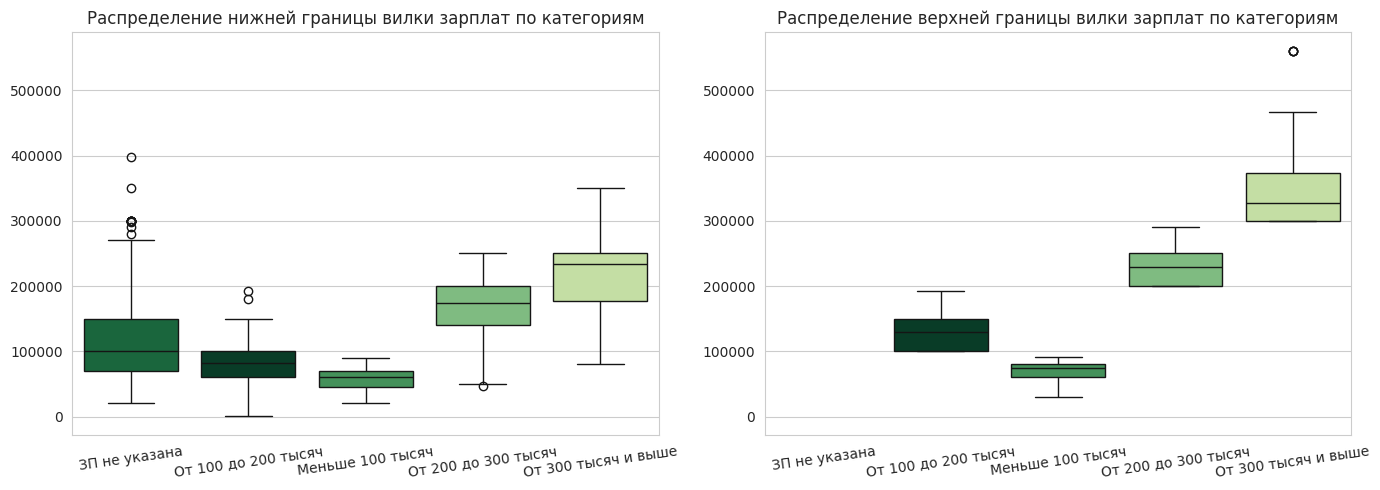

,Вакансий по нижней границе,Минимум,Медиана,Максимум,Вакансий по верхней границе,Минимум,Медиана,Максимум
Категория зарплаты,,,,,,,,
ЗП не указана,481,20000.0,100000.0,398000.0,0,NaN,NaN,NaN
Меньше 100 тысяч,137,20000.0,60000.0,90000.0,182,30000.0,75000.0,92000.0
От 100 до 200 тысяч,212,60.0,82075.0,193000.0,289,100000.0,130000.0,193000.0
От 200 до 300 тысяч,110,46750.0,174500.0,250000.0,174,200000.0,230000.0,290000.0
От 300 тысяч и выше,56,80000.0,233750.0,350000.0,74,300000.0,327250.0,561000.0


In [18]:
#применяем функции
dual_graph(data)
double_table(data)

Как мы можем заметить, указание нижней границы заработной платы не всегда соответствует заявленным категориям. Зато верхняя граница в категориях от 100 тысяч и выше начинается от указанной нижней границы категории. Кроме того, в категориях «От 100 до 200 тысяч», «От 200 до 300 тысяч» и «От 300 тысяч и выше» нижняя граница не совпадает с заявленной в большей части вакансий по категории, медианное значение обычно находится ниже порога вхождения. Также любопытно то, что категория «ЗП не указана» имеет заполненные строки в нижней границе: почти 500 вакансий из имеющихся в этой категории имеют указанный размер зарплаты.

Проверим, сколько вакансий по каждой категории зарплат есть в датасете.

In [19]:
data.groupby('salary_bin').id.count()

salary_bin
ЗП не указана          4238
Меньше 100 тысяч        182
От 100 до 200 тысяч     289
От 200 до 300 тысяч     174
От 300 тысяч и выше      74
Name: id, dtype: int64

Распределение вакансий по категориям соответствует группе вакансий из таблицы по верхней границе уровня зарплаты. Все остальные вакансии попадают в категорию «ЗП не указана».

Для корректного распределения мы можем отсортировать вакансии с указанной нижней границей по категориям в соответствии с имеющейся градацией. Если границы, указанные в категории, не подходят для вилки, сохраним прежнее значение.

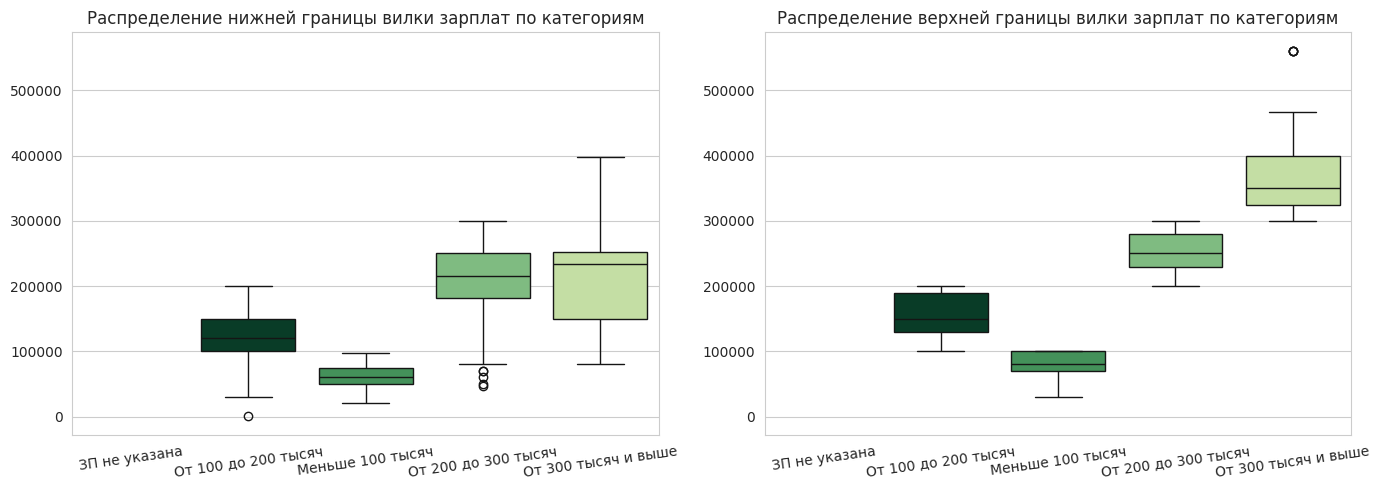

,Вакансий по нижней границе,Минимум,Медиана,Максимум,Вакансий по верхней границе,Минимум,Медиана,Максимум
Категория зарплаты,,,,,,,,
ЗП не указана,0,NaN,NaN,NaN,0,NaN,NaN,NaN
Меньше 100 тысяч,408,20000.0,60450.0,98000.0,255,30000.0,80000.0,100000.0
От 100 до 200 тысяч,412,60.0,120000.0,200000.0,279,101088.0,150000.0,200000.0
От 200 до 300 тысяч,130,46750.0,215000.0,300000.0,130,200000.0,250000.0,300000.0
От 300 тысяч и выше,46,80000.0,233750.0,398000.0,55,300000.0,350000.0,561000.0


In [20]:
#создаём функцию для замены
def salary(row):
    salary_from = row['salary_from']
    salary_to = row['salary_to']
    salary_bin = row['salary_bin']
    try:
        if pd.isnull(salary_from) and pd.isnull(salary_to):
            return 'ЗП не указана'
        elif ((100000 <= salary_from <= 200000 or pd.isnull(salary_from))
              and (100000 < salary_to <= 200000 or pd.isnull(salary_to))):
            return 'От 100 до 200 тысяч'
        elif ((200000 <= salary_from <= 300000 or pd.isnull(salary_from))
              and (200000 < salary_to <= 300000 or pd.isnull(salary_to))):
            return 'От 200 до 300 тысяч'
        elif ((300000 <= salary_from or pd.isnull(salary_from))
              and (300000 < salary_to or pd.isnull(salary_to))):
            return 'От 300 тысяч и выше'
        elif ((pd.isnull(salary_from) or salary_from < 100000)
              and (pd.isnull(salary_to) or salary_to <= 100000)):
            return 'Меньше 100 тысяч'
        else:
            return salary_bin
    except:
        return 'Ошибка'

#применяем функцию с заменой значений в столбце 'salary_bin'
data['salary_bin'] = data.apply(salary, axis=1)

#применяем функции для таблиц и графиков
dual_graph(data)
double_table(data)

Теперь категории зарплат в рамках указанных границ вписаны более корректно, но всё равно есть некоторые выбросы. И если высокая зарплата может быть, то строка с зарплатой от 60 рублей больше похожа на предложение работать за ветку.

Проверим, что скрывается за этой вакансией.

In [21]:
data.query('salary_from == 60')

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job
2379,90431766,Бизнес-аналитик,2023-12-07 10:57:30,https://hh.ru/vacancy/90431766,IT Pro,NaN,Брянск,Junior+ (1-3 years),"['Visiology', 'SQL', 'Бизнес-анализ', 'Докумен...",Полный день,Полная занятость,в свою команду мы ищем бизнес аналитика рассма...,свой команда искать бизнес аналитик рассматрив...,60.0,120000.0,От 100 до 200 тысяч,"Бизнес-анализ, MS PowerPoint, SQL, Power BI, А...",NaN,Документация,Бизнес-аналитик


Вероятнее всего, 60 тысяч были ошибочно указаны как 60 рублей. Мы исправим данные в столбце по индексу.

In [22]:
#заменяем аномально низкую зарплату для индекса 2379
data.loc[2379, 'salary_from'] = 60000
#проверяем замену по id вакансии
data.query('id == 90431766')

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job
2379,90431766,Бизнес-аналитик,2023-12-07 10:57:30,https://hh.ru/vacancy/90431766,IT Pro,NaN,Брянск,Junior+ (1-3 years),"['Visiology', 'SQL', 'Бизнес-анализ', 'Докумен...",Полный день,Полная занятость,в свою команду мы ищем бизнес аналитика рассма...,свой команда искать бизнес аналитик рассматрив...,60000.0,120000.0,От 100 до 200 тысяч,"Бизнес-анализ, MS PowerPoint, SQL, Power BI, А...",NaN,Документация,Бизнес-аналитик


Нижняя граница для строки 2379 успешно заменена. Также проверим выбросы еще в двух категориях, отраженных на графиках.

In [23]:
#выводим срез по выбросам в категориях от 200 тысяч и выше
(data.query('salary_bin in "От 200 до 300 тысяч" and salary_from < 80000 \
        or salary_bin in "От 300 тысяч и выше" and salary_to > 500000').head(10))

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job
486,87893395,Бизнес-аналитик (BPMN),2023-11-08 09:23:39,https://hh.ru/vacancy/87893395,Apko Digitality,NaN,Ташкент,Junior+ (1-3 years),"['CRM', 'Бизнес-анализ', 'Документация', 'Scru...",Полный день,Полная занятость,обязанности: сбор требований от нескольких за...,обязанность сбор требование несколько заинтере...,46750.0,280500.0,От 200 до 300 тысяч,"BPMN, Agile Project Management, Scrum, Управле...",NaN,Документация,Бизнес-аналитик
634,88361281,Специалист по бизнес-аналитике и описанию бизн...,2023-11-15 15:44:13,https://hh.ru/vacancy/88361281,Франчайзинг5,NaN,Казань,Junior+ (1-3 years),['Переговоры'],Удаленная работа,Полная занятость,"«франчайзинг5» — крупнейшая в россии компания,...",франчайзинг5 крупный россия компания оказывать...,60000.0,250000.0,От 200 до 300 тысяч,NaN,NaN,Переговоры,Бизнес-аналитик
676,88438219,Бизнес-аналитик,2024-01-29 09:14:17,https://hh.ru/vacancy/88438219,СтратоСфера,NaN,Нижний Новгород,Junior+ (1-3 years),"['Системное мышление', 'Системный подход', 'Би...",Полный день,Полная занятость,компания стратосфера в связи с устойчивым рост...,компания стратосфера связь устойчивый рост биз...,70000.0,200000.0,От 200 до 300 тысяч,"Системное мышление, Моделирование бизнес проце...",NaN,Документация,Бизнес-аналитик
1922,89825003,Бизнес-аналитик,2023-12-20 11:01:06,https://hh.ru/vacancy/89825003,Эстелинк,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Бизнес-анализ', 'Документация', 'ERP Systems...",Удаленная работа,Полная занятость,"мы it-компания, которая специализируется на ав...",it компания специализироваться автоматизация б...,50000.0,200000.0,От 200 до 300 тысяч,"Бизнес-анализ, Системный анализ, ERP Systems",NaN,Документация,Бизнес-аналитик
2289,90293730,Бизнес-аналитик,2023-12-19 16:49:24,https://hh.ru/vacancy/90293730,СтратоСфера,NaN,Зеленоград,Junior+ (1-3 years),"['Системное мышление', 'Бизнес-анализ', 'Докум...",Полный день,Полная занятость,компания стратосфера в связи с устойчивым рост...,компания стратосфера связь устойчивый рост биз...,70000.0,200000.0,От 200 до 300 тысяч,"Системное мышление, Разработка технических зад...",NaN,Документация,Бизнес-аналитик
4375,88166329,Senior Data Analyst in the marketing department,2023-10-13 16:34:19,https://hh.ru/vacancy/88166329,Реалист,NaN,Москва,Middle (3-6 years),"['MS SQL', 'Python', 'SQL', 'Data Analysis', '...",Удаленная работа,Полная занятость,senior data analyst about the company: realist...,senior data analyst about the company realiste...,280500.0,561000.0,От 300 тысяч и выше,"MS SQL, SQL, Python, Data Analysis, Google Ana...",Юнит-экономика,Принятие решений,Аналитик данных
4411,88420778,Senior Data analyst,2023-10-19 22:14:38,https://hh.ru/vacancy/88420778,ТРТ,NaN,Тбилиси,Senior (6+ years),"['Python', 'Statistics', 'Analytical skills', ...",Удаленная работа,Полная занятость,the team of experts providing analytical servi...,the team of experts providing analytical servi...,233750.0,561000.0,От 300 тысяч и выше,"Data Analysis, Python, Analytical skills, SQL,...",Юнит-экономика,"Коммуникация, Презентация результатов, Критиче...",Аналитик данных
4632,89971604,Senior Data analyst,2023-11-27 11:41:45,https://hh.ru/vacancy/89971604,ТРТ,NaN,Тбилиси,Senior (6+ years),"['Python', 'Statistics', 'Analytical skills', ...",Удаленная работа,Полная занятость,the team of experts providing analytical servi...,the team of experts providing analytical servi...,233750.0,561000.0,От 300 тысяч и выше,"Data Analysis, Python, Analytical skills, SQL,...",Юнит-экономика,"Коммуникация, Презентация результатов, Критиче...",Аналитик данных
4673,90238915,Senior Data analyst,2023-12-03 19:56:00,https://hh.ru/vacancy/90238915,ТРТ,NaN,Батуми,Senior (6+ years),"['Python', 'Statistics', 'Analytical skills', ...",Удаленная рабо

Выбросы не так уж аномальны.
- Senior может претендовать на зарплату выше 500 тысяч.
- Некоторые компании могут указывать высокую зарплату с учётом премий при невысоком окладе.

Эти выбросы мы никак исправлять не будем.

### Изучим даты публикации вакансий в `published_at`

Выведем диапазон дат, представленных в датасете.

In [24]:
#дата первой опубликованной вакансии из датасета
data['published_at'].min()

Timestamp('2023-09-26 18:38:02')

In [25]:
#дата последней опубликованной вакансии из датасета
data['published_at'].max()

Timestamp('2024-01-30 15:58:58')

У нас есть информация о вакансиях, опубликованных с 26 сентября 2023 года до 30 января 2024 года. Для анализа помесячной динамики дни нам не потребуются. Создадим новый столбец с месяцем и годом публикации вакансий.

In [26]:
#создаём новый столбец с месяцами
data['month'] = data['published_at'].dt.to_period('M')
#проверяем результат
data.groupby('month').id.count()

month
2023-09      15
2023-10     483
2023-11    1369
2023-12    1048
2024-01    2042
Freq: M, Name: id, dtype: int64

В сентябре из-за малого количества дней в датасет попало минимальное количество предложений.



### Изучим названия вакансий в `name`

В таблице «ba» было 1550 уникальных значений, а в таблице «da» — 344. Рассмотрим список наименований вакансий для аналитиков данных, так как их меньше, но суть одна.

In [27]:
list(data.query('job == "Аналитик данных"')['name'].sort_values().unique()[:10])

['BI-инженер/Senior Data analyst (Tableau)',
 'BI/Data Analyst (Qlik)',
 'Big Data Analyst',
 'Big Data Analyst (Аналитик)',
 'CRM Data Analyst',
 'Chatbot data analyst',
 'Customer Service Data Analyst',
 'Data Analyst',
 'Data Analyst "Growth"',
 'Data Analyst "Growth" (junior/middle)']

Итак, что мы имеем:
- Название специальности может быть написано по-разному: на латинице и на русском языке, строчными и прописными буквами.
- В названии вакансии могут быть указаны названия компании, локация, детализация сферы (например, геймдев или веб-аналитика) и опыт работы или позиция в команде.

Для решения нашей задачи нам может быть интересен только опыт работы для сравнения с соответствующим столбцом. В таком случае тщательная обработка названий вакансий не имеет смысла, поэтому выделим опыт работы во временный столбец для сравнения и оставим названия вакансий без изменений.


In [28]:
#создаём функцию для выделения грейдов из названий вакансий
def grade(row):
    try:
        row = row.lower()
        if 'junior+' in row or 'pre-middle' in row:
            return 'junior+'
        elif 'junior' in row and 'middle' in row:
            return 'junior/middle'
        elif 'junior' in row or 'младший' in row:
            return 'junior'
        elif 'middle' in row and 'senior' in row:
            return 'middle/senior'
        elif 'middle' in row:
            return 'middle'
        elif 'senior' in row or 'cтaрший' in row or 'глaвный' in row or 'вeдущий' in row:
            return 'senior'
        else:
            return pd.NA
    except:
        return pd.NA
#применяем функцию
data['grade_in_name'] = data['name'].apply(grade)
#проверяем на сводной таблице
data.pivot_table(index='experience', columns='grade_in_name',values='id',aggfunc='count')

grade_in_name,junior,junior+,junior/middle,middle,middle/senior,senior
experience,,,,,,
Junior (no experince),69.0,NaN,NaN,3.0,NaN,NaN
Junior+ (1-3 years),101.0,9.0,4.0,64.0,12.0,6.0
Middle (3-6 years),1.0,NaN,2.0,37.0,21.0,132.0
Senior (6+ years),NaN,NaN,NaN,1.0,3.0,14.0


По этой сводной таблице можно заметить, что в названиях вакансий требования к кандидатам могут быть завышены, хотя сама вакансия указана на меньший опыт работы.

Мы не будем изменять данные в столбце `experience`, но будем иметь в виду, что сами наименования вакансий могут содержать другую информацию об ожиданиях в отношении опыта кандидата.

### Изучим работодателей в `employer`

In [29]:
list(data['employer'].sort_values().unique()[:10])

['1-й Советник',
 '12 STOREEZ',
 '1221Системс',
 '1C-Рарус',
 '1service',
 '21 Век, группа компаний',
 '21vek.by',
 '2ГИС',
 '3205.team',
 '42Clouds']

Неявных дубликатов нет. Сервис hh.ru предполагает регистрацию работодателей, а затем вносит их в свою базу. Поэтому неявным дубликатам просто неоткуда взяться.

Некоторые крупные корпорации имеют несколько холдингов с разными названиями, но работа и найм в них происходит независимо от других подразделений, поэтому объединять их мы не будем.

### Изучим отделы работодателей в `department`

In [30]:
list(data['department'].sort_values().unique()[:10])

[' ITMS Finance',
 ' ITMS Marketing',
 ' Альфа-Банк',
 ' Информационные технологии',
 ' О’КЕЙ ИТ',
 '"Евросиб, Управляющая компания"',
 '"Сибинтек-Софт"',
 'ABSOL',
 'BI.ZONE Направление Информационные технологии',
 'Boxberry: Офис']

В наименованиях департаментов есть лишние пробелы, но неявных дубликатов не наблюдается.

In [31]:
data['department'] = data['department'].str.strip().str.replace('  ',' ', regex=True)
list(data['department'].sort_values().unique()[:10])

['"Евросиб, Управляющая компания"',
 '"Сибинтек-Софт"',
 'ABSOL',
 'BI.ZONE Направление Информационные технологии',
 'Boxberry: Офис',
 'Digital & IT',
 'Fix Price. Офис',
 'ITMS Finance',
 'ITMS Marketing',
 'Ozon Fintech']

Пробелы в наименовании отделов устранены, пропуски трогать не будем: не все компании настолько велики, чтобы искать специалиста в определённый отдел.

### Изучим регионы мест работы в `area`


In [32]:
list(data['area'].sort_values().unique()[:10])

['Аксай (Казахстан)',
 'Алматы',
 'Альметьевск',
 'Армения',
 'Архангельск',
 'Астана',
 'Астрахань',
 'Атырау',
 'Баку',
 'Балашиха']

Среди локаций большое количество российских городов, но есть и некоторое количество наименований стран.
В этом списке локаций упоминаются следующие страны:
- Азербайджан
- Армения
- Беларусь
- Грузия
- Казахстан
- Кипр
- Кыргызстан
- Россия
- США
- Сербия
- Турция
- Узбекистан
- Черногория

Возможно, будет более корректно разделить страны и города по разным столбцам.

Создадим функцию, которая отсортирует имеющиеся города по этим странам в двух новых столбцах. Чтобы избежать пропусков, в строках, где указана только страна, мы будем использовать её же в столбце с городом.

In [33]:
#функция для разделения стран и городов
def locations(row, sep = '('):
    area = row.split(sep=sep)
    if ('Аксай' in area[0] or 'Алматы' in area[0] or 'Атырау' in area[0]
        or 'Караганда' in area[0] or 'Костанай' in area[0] or 'Астана' in area[0]):
        return 'Казахстан', area[0]
    elif ('Барановичи' in area[0] or 'Брест' in area[0] or 'Витебск' in area[0]
          or 'Гомель' in area[0] or 'Гродно'in area[0] or 'Минск'in area[0] or 'Могилев'in area[0]):
        return 'Беларусь', area[0]
    elif 'Батуми' in area[0] or 'Тбилиси' in area[0]:
        return 'Грузия', area[0]
    elif 'Ташкент' in area[0]:
        return 'Узбекистан', area[0]
    elif 'Бишкек' in area[0]:
        return 'Кыргызстан', area[0]
    elif 'Баку' in area[0]:
        return 'Азербайджан', area[0]
    elif ('Армения' in area[0] or 'Турция' in area[0] or 'США' in area[0]
          or 'Сербия' in area[0] or 'Черногория' in area[0] or 'Кипр' in area[0]):
        return area[0], area[0]
    else:
        return 'Россия', area[0]
#применяем функцию
data[['country', 'city']] = data['area'].apply(locations, sep='(').apply(pd.Series)

#проверяем результат
data.head()

,id,name,published_at,alternate_url,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,job,month,grade_in_name,country,city
0,49470036,Бизнес-аналитик,2024-01-29 21:09:56,https://hh.ru/vacancy/49470036,ICS Consulting,NaN,Москва,Junior+ (1-3 years),"['Умение работать с людьми', 'Документация', '...",Полный день,Полная занятость,на основе конкурсного отбора обязанности учас...,основа конкурсный отбор обязанность участие ко...,90000.0,120000.0,От 100 до 200 тысяч,"Грамотность, Деловая переписка, Умение работат...",NaN,"Коммуникация, Документация, Переговоры",Бизнес-аналитик,2024-01,<NA>,Россия,Москва
1,55186681,"Проектный бизнес-аналитик 1С (ERP, УХ, КА, УТ,...",2024-01-10 11:00:30,https://hh.ru/vacancy/55186681,Первый Бит,NaN,Москва,Middle (3-6 years),"['1С: Документооборот', '1С: Управление Произв...",Полный день,Полная занятость,"привет, будущий коллега!мы приглашаем проектны...",привет будущий коллега приглашать проектный ан...,NaN,NaN,ЗП не указана,"Управление проектами, Бизнес-анализ, Системный...",NaN,NaN,Бизнес-аналитик,2024-01,<NA>,Россия,Москва
2,67043806,Бизнес-аналитик,2023-11-15 17:46:22,https://hh.ru/vacancy/67043806,Digital Design,NaN,Москва,Junior+ (1-3 years),"['Разработка проектной документации', 'Электро...",Полный день,Полная занятость,digital design более четверти века разрабатыва...,digital design четверть век разрабатывать внед...,NaN,NaN,ЗП не указана,"Разработка проектной документации, Разработка ...",NaN,"Коммуникация, Документация",Бизнес-аналитик,2023-11,<NA>,Россия,Москва
3,67345392,"Бизнес-аналитик (по логистике морских портов, ...",2024-01-17 12:53:15,https://hh.ru/vacancy/67345392,СОЛВО,NaN,Санкт-Петербург,Middle (3-6 years),"['IDEF0', 'Документация', 'Аналитическое мышле...",Полный день,Полная занятость,солво – лидер российского рынка it решений для...,солво лидер российский рынок it решение автома...,NaN,NaN,ЗП не указана,"UML, BPMN, IDEF0, Английский язык, IDEF",NaN,"Документация, Аналитическое мышление",Бизнес-аналитик,2024-01,<NA>,Россия,Санкт-Петербург
4,67498251,Бизнес-аналитик в Банк,2024-01-29 12:05:14,https://hh.ru/vacancy/67498251,Сателл ИТ,NaN,Москва,Junior+ (1-3 years),"['Бизнес-анализ', 'Документация']",Удаленная работа,Полная занятость,"обязанности: анализ бизнес-процессов; сбор, а...",обязанность анализ бизнес процесс сбор анализ ...,200000.0,NaN,От 100 до 200 тысяч,Бизнес-анализ,NaN,Документация,Бизнес-аналитик,2024-01,<NA>,Россия,Москва


Столбцы успешно добавлены, посчитаем, сколько на каждую страну приходится вакансий, чтобы проверить результаты работы функции.

In [34]:
#проверка через сводную таблицу
data.pivot_table(index='country', values='id', aggfunc='count')

,id
country,
Азербайджан,2
Армения,5
Беларусь,228
Грузия,24
Казахстан,80
Кипр,7
Кыргызстан,9
Россия,4548
США,1


Функция сработала корректно. Добавлены два новых столбца со странами и городами.

Перейдем к обработке самых сложных столбцов, содержащих информацию о навыках, которые работодатели ожидают от кандидатов в опубликованных вакансиях.

### Изучим ключевые навыки

In [35]:
#выведем описательную статистику по столбцам с навыками
(data[['key_skills','key_skills_from_key_skills_field','hard_skills_from_description','soft_skills_from_description']]
 .describe(include=['object']).T)

,count,unique,top,freq
key_skills,4957,2313,[],682
key_skills_from_key_skills_field,3168,2195,"1С: Бухгалтерия, 1С: Предприятие 8, ERP-систем...",33
hard_skills_from_description,929,9,confluence,632
soft_skills_from_description,2850,88,Документация,1371


Столбцы с предобработанными навыками hard и soft имеют пропуски и небольшое количество уникальных значений, в то время как в ключевых столбцах `key_skills` и `key_skills_from_key_skills_field` можно увидеть большое разнообразие вариаций.

Важно отметить, что в `key_skills` пропусков система не видит, но ячейка в виде `[]` повторяется 682 раза и не несет смысловой нагрузки. Однако разница между количеством заполненных строк в столбце `key_skills` и количеством фактически пропущенных строк в виде `[]` меньше, чем количество заполненных строк в столбце `key_skills_from_key_skills_field`.

Поскольку эти две колонки содержат ключевые навыки, собранные при анализе полного текста вакансии, обрабатывать их обе нецелесообразно. Мы проверим, какие наборы навыков встречаются чаще всего в каждой из них, и оставим для анализа только один столбец.



In [36]:
#выведем топ-строк с ключевыми навыками из key_skills
(data.pivot_table(index='key_skills',values='id',aggfunc='count')
.sort_values(by='id',ascending=False).head())

,id
key_skills,
[],682
['Документация'],359
"['confluence', 'Документация']",93
"['Документация', 'Коммуникация']",90
['Коммуникация'],89


У бизнес-аналитиков и аналитиков данных требования могут различаться, проверим эти различия в срезе. Всё же доля вакансий для аналитиков данных значительно меньше — и в общем датасете особенности могут затеряться.

In [37]:
#добавим срез по аналитикам данных
(data.query('job == "Аналитик данных"')
.pivot_table(index='key_skills',values='id',aggfunc='count')
.sort_values(by='id',ascending=False).head())

,id
key_skills,
[],129
['Pandas'],43
"['Python', 'Product Analytics', 'SQL', 'Data Analysis', 'Big Data']",21
['Коммуникация'],14
['Документация'],14


In [38]:
#добавим срез по бизнес-аналитикам
(data.query('job == "Бизнес-аналитик"')
.pivot_table(index='key_skills',values='id',aggfunc='count')
.sort_values(by='id',ascending=False)
.head())

,id
key_skills,
[],553
['Документация'],345
"['confluence', 'Документация']",91
"['Документация', 'Коммуникация']",88
['Коммуникация'],75


Разница действительно существенная.
- Для аналитика данных часто требуется знание библиотеки Pandas, а также владение языками программирования Python и SQL.
- А для бизнес-аналитика ключевыми навыками являются умение работать с документацией и платформой Confluence.

Давайте посмотрим, насколько сильно отличаются ключевые навыки в столбце `key_skills_from_key_skills_field`.

In [39]:
#выведем топ-строк с ключевыми навыками из `key_skills_from_key_skills_field`
(data.pivot_table(index='key_skills_from_key_skills_field',values='id',aggfunc='count')
.sort_values(by='id',ascending=False)
.head(10))

,id
key_skills_from_key_skills_field,
"1С: Бухгалтерия, 1С: Предприятие 8, ERP-системы на базе 1С, Бухгалтерский учет, Аналитик 1С, Бизнес-анализ, 1С: Зарплата и управление персоналом, 1С: Документооборот, Аналитическое мышление, Автоматизация процессов управления персоналом",33
Бизнес-анализ,30
"UML, SQL, Business Analysis",23
"Бизнес-анализ, Работа в команде, Моделирование бизнес процессов, Функциональные требования",18
ERP-системы на базе 1С,16
"Product Analytics, Python, SQL, Data Analysis, Big Data",15
"SQL, Python",13
SQL,12
"Tableau, SQL, Python, SAP Business Objects, Аналитическое мышление, Сбор и анализ информации, BI",12


Данные, которые были внесены в столбец `key_skills_from_key_skills_field`, прошли предварительную обработку. Есть предположение, что часто встречающиеся варианты в `key_skills` были во время предобработки разнесены в столбцы с твердыми и мягкими навыками, из-за чего возникли пропуски в текущей колонке.

Для анализа нам потребуется максимально полная база навыков, которые встречаются в вакансиях, поэтому мы будем работать со столбцом `key_skills`.

### Поработаем над ключевыми навыками из `key_skills`

Столбцы, хранящие информацию о требуемых навыках, содержат разные и часто уникальные значения — это может вызвать трудности при анализе, а потому эти данные можно вынести в отдельную таблицу, где идентификатором послужат id вакансий, а сами навыки станут столбцами. Такой способ позволит изучить имеющиеся уникальные навыки и через исправление функции минимизировать неявные дубликаты.

Но прежде чем приступить к созданию новой таблицы, приведем текст в столбце к единому виду.

In [40]:
#функция для простейшей обработки столбцов
def rename_data(df):
    rename_data = (df.str.lower()
    .str.replace('[','')
    .str.replace(']','')
    .str.replace('(','')
    .str.replace(')','')
    .str.replace("'",'')
    .replace('', None))
    return rename_data

#применяем функцию rename_data к столбцам с навыками
data['key_skills'] = rename_data(data['key_skills'])
data['hard_skills_from_description'] = rename_data(data['hard_skills_from_description'])
data['soft_skills_from_description'] = rename_data(data['soft_skills_from_description'])
#выведем часть списка из key_skills после применения функции
list(data['key_skills'].sort_values().unique())[:5]

['1c erp, 1с: управление производственным предприятием, 1с упп, грамотная письменная речь, 1c: упп, анализ бизнес показателей, умение работать с людьми, создание конфигурации 1с, erp-системы на базе 1с, коммуникация, умение анализировать, erp, аналитическое мышление, 1с: erp, эдо, 1с: управление предприятием, excel',
 '1c erp, axelot x5, erp-системы на базе 1с, аналитическое мышление, wms, 1с аналитик',
 '1c erp, confluence, документация, erp, uml, мсфо, bpmn, epc',
 '1c erp, erp-системы на базе 1с, аналитическое мышление, 1с аналитик, производственный учет',
 '1c erp, бизнес-анализ, автоматизация, оптимизация бизнес-процессов, erp, разработка технических заданий']

В списке навыков второй выведенной строки можно увидеть дубли одного навыка: `1c erp` и `1c: erp`.

Очистка таких дубликатов потребует времени и регулярной проверки результатов, поэтому создадим несколько функций, чтобы проверки и корректировки занимали меньше времени.

Чтобы проверить все значения из столбца `key_skills` на наличие неявных дубликатов и сгруппировать основные инструменты и навыки, создадим отдельный список со всеми уникальными значениями столбца.

In [41]:
#функция для выделения списка уникальных значений
def get_unique_skills(df, row):
    #делим строки в столбце row по запятым, пропуская значения None
    key_skills_list = df[row].dropna().str.split(',').tolist()
    #собираем все значения из строк по столбцу в один плоский список
    key_skills_list = [skill.strip() for sublist in key_skills_list for skill in sublist if skill.strip()]
    #выбираем уникальные значения
    unique_skills = list(set(key_skills_list))
    #выводим уникальные значения
    size_list = len(unique_skills)
    return unique_skills, size_list

In [42]:
#применяем функцию get_unique_skills
unique_skills, size_list = get_unique_skills(data,'key_skills')
#выводим размер уникального списка
display(size_list)
#выводим уникальные значения
unique_skills[:10]

1733

['проверка контрагентов',
 'itil',
 'unix shell scripts',
 'управление проектом',
 'микросервисная архитектура',
 'подготовка технических заданий по автоматизации',
 'умение систематизировать информацию',
 'понимание принципов построения архитектуры по',
 'google cloud',
 'санкции']

Мы сформировали список из 1733 уникальных навыков, которые необходимо обработать. К сожалению, такой большой объем данных невозможно выгрузить единовременно, поэтому мы будем использовать несколько внешних инструментов. С помощью Excel мы выведем весь список и изучим его, а затем будем вручную и с помощью ChatGPT искать неявные дубликаты среди инструментов и навыков — и группировать их.

In [43]:
#сохраняем уникальные значения в CSV файл
unique_skills = pd.DataFrame(unique_skills, columns=['unique_skills'])
unique_skills.to_csv('unique_skills.csv', index=False)

Некоторые навыки могут содержать опечатки и различные варианты написания. Поэтому создадим функцию, которая будет принимать на вход необработанные строки `key_skills` и затем переименовывать значения по группам. Это позволит также использовать метод `replace` для замены наименований по частям слов.

In [44]:
#функция для группировки значений навыков в строках неизменённой таблицы
def group_skills(column, key_skills, regex_key_skills):
    if pd.notna(column):  #проверяем, что значение не является пропуском
        #разделяем значения по запятой и преобразуем к нижнему регистру
        skills_list = [skill.lower().strip() for skill in column.split(', ')]
        #функция для проверки наличия ключевого слова в навыке
        def check_key_skills(skill):
            for key_skill in regex_key_skills:
                #используем регулярное выражение для поиска ключевого слова в навыке
                pattern = re.compile(r'\b' + re.escape(key_skill) + r'\b')
                if re.search(pattern, skill):
                    return key_skill
            for key_skill in key_skills:
                if key_skill in skill:
                    return key_skill
            return skill
        #применяем функцию проверки к каждому навыку в списке
        processed_skills = [check_key_skills(skill) for skill in skills_list]
        #объединяем преобразованные навыки обратно в строку
        processed_skills_string = ', '.join(processed_skills)
        return processed_skills_string
    else:
        return None

In [45]:
#производим замену опечаток и разнонаписанных синонимических значений
data['key_skills'] = (data['key_skills'].str.strip()
                                        .str.replace(r'\bbi\b', 'bi-системы', regex=True)
                                        .str.replace('!с: управление нашей фирмой','1с', regex=True)
                                        .str.replace('1 с предприятие','1с', regex=True)
                                        .str.replace(r'(анти\s?[-\s]?фрод)|(anti[-\s]?fraud)', 'антифрод', regex=True)
                                        .str.replace(r'(а/в|a/b|ab) тест(ирование|ы)?', 'a/b тесты', regex=True)
                                        .str.replace('a/b-тестирование','a/b тесты', regex=True)
                                        .str.replace('223 -фз','нормативные акты', regex=True)
                                        .str.replace('гост','нормативные акты', regex=True)
                                        .str.replace('норматив','нормативные акты', regex=True)
                                        .str.replace('автоматизация', 'моделирование бизнес-процессов', regex=True)
                                        .str.replace('оптимизация бизнес','моделирование бизнес-процессов', regex=True)
                                        .str.replace('английск','английский язык', regex=True)
                                        .str.replace('english','английский язык', regex=True)
                                        .str.replace('грамотная','грамотность', regex=True)
                                        .str.replace('русск','грамотность', regex=True)
                                        .str.replace('oracle','sql', regex=True)
                                        .str.replace('отчет','отчетность', regex=True)
                                        .str.replace('анализ абс','abc-анализ', regex=True)
                                        .str.replace('ad hoc analysis','ad hoc', regex=True)
                                        .str.replace('bitrix','битрикс', regex=True)
                                        .str.replace('тз','работа с тз', regex=True)
                                        .str.replace('бд','базы данных', regex=True)
                                        .str.replace('витрин','дашборды', regex=True)
                                        .str.replace('googlesheets','google sheets', regex=True)
                                        .str.replace('срм','crm', regex=True)
                                        .str.replace('офис','office', regex=True)
                                        .str.replace('работать в к','работа в команде', regex=True)
                                        .str.replace('в2в','b2b', regex=True)
                                        .str.replace('draw io','draw.io', regex=True)
                                        .str.replace('erp и учетные системы','erp', regex=True)
                                        .str.replace('roi','юнит-экономика', regex=True)
                                        .str.replace('tableu','tableau', regex=True)
                                        .str.replace('use-кейсы','use case', regex=True)
                                        .str.replace('userstory','user story', regex=True)
                                        .str.replace('аккуратность','внимание к деталям', regex=True)
                                        .str.replace('time management','тайм-менеджмент', regex=True)
                                        .str.replace('презентац','презентация результатов', regex=True)
                                        .str.replace('communication skills','коммуникация', regex=True)
                                        .str.replace('ответственност','ответственность', regex=True)
                                        .str.replace('документ','документация', regex=True)
                                        .str.replace('перегов','переговоры', regex=True)
                                        .str.replace('обуча','обучаемость', regex=True)
                                        .str.replace('многозадач','многозадачность', regex=True)
                                        .str.replace('leadership skills','лидерство', regex=True)
                                        .str.replace('ui/ux','ux/ui', regex=True)
                                        .str.replace('ux тестирования','ux', regex=True)
                                        .str.replace('plotly','python', regex=True)
                                        .str.replace('seaborn','python', regex=True)
                                        .str.replace('jupyter','python', regex=True)
                                        .str.replace('matplotlib','python', regex=True)
                                        .str.replace('numpy','python', regex=True)
                                        .str.replace('pandas','python', regex=True)
                                        .str.replace('визуализация','bi-системы', regex=True)
                                        .str.replace('визуализация данных','bi-системы', regex=True)
                                        .str.replace('инструменты визуализации','bi-системы', regex=True)
                                        .str.replace('системы bi','bi-системы', regex=True)
                                        .str.replace('bi инструмент','bi-системы', regex=True)
                                        .str.replace('powershel','powershell', regex=True)
                                        .str.replace('modus bi-системы','modus bi', regex=True)
                                        .str.replace('pivot','power pivot', regex=True)
                                        .str.replace('machine learning','ml', regex=True)
                                        .str.replace('исполнение поручений руководителя','исполнительность', regex=True)
                                        .str.replace('маркеплейсы','маркетплейс', regex=True)
                                        .str.replace('ответственн','ответственность', regex=True)
                                        .str.replace('теория вероятностей','теория вероятности', regex=True)
                                        .str.replace('решения','принятие решений', regex=True)
                                        .str.replace('самостоятельно','самостоятельность', regex=True)
                                        .str.replace('управление','управленческие навыки', regex=True)
                                        .str.replace('гипотез','работа с гипотезами', regex=True)
                                        .str.replace('яндекс.метрика','яндекс метрика', regex=True)
                                        .str.replace('presale','pre-sales', regex=True)
                                        .str.replace('qa','тестирование', regex=True)
                                        .str.replace('большие массивы данных','big data', regex=True)
                                        .str.replace('больш','работа с большим объемом информации', regex=True)
                                        .str.replace('аналитический склад ума','аналитическое мышление', regex=True)
                                        .str.replace('negotiation skills','переговоры', regex=True)
                                        .str.replace('presentation skills','презентация результатов', regex=True)
                                        .str.replace('бизнес аналитик','бизнес-аналитика', regex=True)
                                        .str.replace('business analysis','бизнес-аналитика', regex=True)
                                        .str.replace('data analysis','аналитика', regex=True)
                                        .str.replace('финансовых показателей','анализ бизнес показателей', regex=True)
                                        .str.replace(r'\bаналитик\b', 'аналитика', regex=True)
                                        .str.replace('statistics','статистика', regex=True)
                                        .str.replace('управленческие навыки','лидерство', regex=True)
                                        )
#создаем список ключевых слов для группировок
keywords = (['1с','нормативные акты','моделирование бизнес-процессов','английский язык','аналитическое мышление',
             'статистика','битрикс','sql','отчетность','crm','confluence','jira','agile','apache','as is',
             'работа с тз','базы данных','excel','гибкость','python','word','маркетплейс','raci','bpmn','дашборды',
             'грамотность','uml','office','работа в команде','b2b','b2c','camunda','elma','api','figma','grafana',
             'json','visio','olap','sap','use case','user case','user story','draw.io','внимание к деталям',
             'презентация результатов','коммуникация', 'ответственность','документация','переговоры','обучаемость',
             'навыки продаж','многозадачность','bi-системы','power point','power query','power pivot','access',
             'стрессоустойчивость','принятие решений','самостоятельность','управленческие навыки',
             'работа с гипотезами','алгоритмы','работа с большим объемом информации','бизнес-аналитика'])
#создаем список ключевых слов для группировки в регулярном выражении
regex_key_skills = (['аналитика'])

In [46]:
#применяем функцию group_skills к столбцу key_skills
data['key_skills'] = data['key_skills'].apply(lambda x: group_skills(x, keywords, regex_key_skills))
#проверяем результат функцией get_unique_skills
unique_skills, size_list = get_unique_skills(data,'key_skills')
#выводим размер уникального списка
size_list

1135

Мы смогли сократить количество навыков с 1733 до 1135 значений. Удалим из строк дубликаты, которые возникли в процессе группировки и замены значений ранее, а также наименования, которые встречаются в перечне навыков не более двух раз.

In [47]:
#функция для удаления дублей в общем списке значений
def remove_duplicates(skill_string, rare_values):
    if isinstance(skill_string, str):
        #разбиваем строку на отдельные навыки
        skills_list = skill_string.split(', ')
        #удаляем редко встречающиеся значения
        filtered_skills = [skill for skill in skills_list if skill not in rare_values]
        #возвращаем строку с уникальными навыками
        return ', '.join(set(filtered_skills))
    else:
        return None

In [48]:
#разделяем строки на отдельные значения и создаём единый список навыков
all_skills = ', '.join([str(skill) for skill in data['key_skills'] if skill is not None]).split(', ')
#очищаем список от пропусков
all_skills_cleaned = [skill for skill in all_skills if skill is not None]
#считаем количество упоминаний каждого навыка
skill_counts  = pd.Series(all_skills_cleaned ).value_counts()
#сохраняем навыки, которые встречаются больше 2 раз
rare = skill_counts [skill_counts  <= 2]

#применяем функцию remove_duplicates
data['key_skills'] = data['key_skills'].apply(lambda x: remove_duplicates(x, rare.index))
#проверяем результат функцией get_unique_skills
unique_skills, size_list = get_unique_skills(data,'key_skills')
#выводим размер уникального списка
display(size_list)
#проверяем результат
data.pivot_table(index='key_skills',values='id',aggfunc='count').sort_values(by='id',ascending=False).head()

429

,id
key_skills,
документация,359
"документация, confluence",93
"коммуникация, документация",91
коммуникация,89
аналитическое мышление,75


В строках больше нет дубликатов, а навыки стали более единообразны. Количество уникальных навыков сократилось до 429 значений. Посмотрим, что у нас осталось в столбце `key_skills`.

In [49]:
#выводим статистику по столбцам с навыками
data[['key_skills','key_skills_from_key_skills_field']].describe(include=['object'])

,key_skills,key_skills_from_key_skills_field
count,4275,3168
unique,2214,2195
top,документация,"1С: Бухгалтерия, 1С: Предприятие 8, ERP-систем..."
freq,359,33


В сравнении с предобработанным столбцом `key_skills_from_key_skills_field` пропусков в `key_skills` меньше: 4275 заполненных строк против 3168. Уникальных строк получилось больше в обработанном нами столбце, но незначительно: 2195 уникальных строк против 2210 в `key_skills`.

Теперь можно приступить к сортировке уникальных навыков на soft и hard. Выведем наиболее популярные навыки по каждой из вакансий.

In [50]:
#разделяем строки на отдельные значения и создаём единый список навыков
all_skills_ba = ', '.join([str(skill) for skill in data.query('job == "Бизнес-аналитик"')['key_skills']
                           if skill is not None]).split(', ')
#очищаем список от пропусков
all_skills_cleaned_ba = [skill for skill in all_skills_ba if skill is not None]
#считаем количество упоминаний каждого навыка
skill_counts_ba = pd.Series(all_skills_cleaned_ba).value_counts()
#выводим результат из первых 10 строк
skill_counts_ba.iloc[:10]

документация                      1983
бизнес-анализ                     1476
моделирование бизнес-процессов    1078
аналитическое мышление            1073
коммуникация                       842
bpmn                               784
работа с тз                        659
аналитика                          650
confluence                         648
sql                                634
Name: count, dtype: int64

In [51]:
#разделяем строки на отдельные значения и создаём единый список навыков
all_skills_da = ', '.join([str(skill) for skill in data.query('job == "Аналитик данных"')['key_skills']
                           if skill is not None]).split(', ')
#очищаем список от пропусков
all_skills_cleaned_da = [skill for skill in all_skills_da if skill is not None]
#считаем количество упоминаний каждого навыка
skill_counts_da = pd.Series(all_skills_cleaned_da).value_counts()
#выводим результат из первых 10 строк
skill_counts_da.iloc[:10]

sql                       464
python                    462
аналитика                 284
bi-системы                184
аналитическое мышление    132
документация              113
коммуникация              108
big data                   89
базы данных                72
a/b тесты                  67
Name: count, dtype: int64

Учитывая непропорциональное количество вакансий между аналитиками данных и бизнес-аналитиками, определить точную границу в количестве самых важных навыков не представляется возможным. Так как выборка аналитиков данных небольшая, некоторые навыки могут не иметь большого веса, несмотря на свою ценность.

По этой причине воспользуемся возможностями ChatGPT для распределения навыков на твёрдые и мягкие из всего списка key_skills.

### Поработаем над "мягкими" навыками из `soft_skills_from_description`

Выведем список с информацией об имеющихся уже soft-навыках.

In [52]:
#достаем уникальный список навыков из soft_skills_from_description функцией get_unique_skills
unique_skills, size_list = get_unique_skills(data,'soft_skills_from_description')
#выводим размер уникального списка и список навыков
display(size_list)
unique_skills[:10]

17

['переговоры',
 'принятие решений',
 'внимание к деталям',
 'письменная коммуникация',
 'проактивность',
 'коммуникация',
 'документация',
 'креативность',
 'тайм-менеджмент',
 'эмпатия']

У нас представлено 17 мягких навыков в отдельном столбце.

In [53]:
#функция для добавления нового столбца с разбивкой по скиллам
def check_and_add_skills(df, skills_list, skills, type_skills):
    #создаем пустой новый столбец
    df[type_skills] = ''
    #проходимся по строкам
    for index, row in df.iterrows():
        #проверяем тип значений в обоих столбцах
        if isinstance(row['key_skills'], str) or isinstance(row[skills], str):
            #объединяем значения из двух столбцов в одну строку
            combined_skills = (row['key_skills']
                               if isinstance(row['key_skills'], str) 
                               else '') + ' ' + (row[skills]
                                                 if isinstance(row[skills], str) 
                                                 else '')
            #проходимся по списку навыков для проверки
            for skill in skills_list:
                #если навык присутствует в строке, добавляем его в пустой столбец
                if skill in combined_skills:
                    df.at[index, type_skills] += skill + ', '
    #удаляем лишние запятые в конце строк
    df[type_skills] = df[type_skills].str.rstrip(', ').replace('', None)
    return df

In [54]:
#список мягких навыков
soft_skills_list = ['работа в команде','грамотность','коммуникация','критическое мышление','многозадачность', 
                    'отчетность','переговоры','презентация результатов','принятие решений','проактивность', 
                    'тайм-менеджмент','работа с большим объемом информации','работа с тз','решение проблем', 
                    'управленческие навыки','организаторские навыки','аналитическое мышление','стрессоустойчивость',
                    'клиентоориентированность','терпеливость','наставничество','самостоятельность','гибкость',
                    'ориентация на результат','обучение и развитие','адаптивность','внимание к деталям', 
                    'консультация клиентов','стремление к профессиональному росту','умение анализировать', 
                    'сбор и анализ информации','умение слушать','самоорганизация','организация семинаров',
                    'руководство командой разработчиков','аналитические исследования','сосредоточенность', 
                    'ответственность','прототипирование','поиск информации в интернет','деловая переписка', 
                    'прогнозирование','эмпатия','написание инструкций','оценка потребностей клиентов',
                    'обучаемость','формирование гипотез','анализ бизнес показателей','умение анализировать риски',
                    'написание процедур','проведение собеседований','разработка и внедрение политик и процедур',
                    'анализ организационной структуры компании','обучение персонала','системный подход',
                    'формулирование требований к процессу to be','стратегическое мышление','разработка концепции',
                    'разработка регламентов','организация консультаций','написание технической документации',
                    'написание бизнес-плана','генерация идей','запуск новых продуктов','лидерство','креативность',
                    'письменная коммуникация','документация']
#применяем функцию check_and_add_skills
data = check_and_add_skills(data, soft_skills_list, 'soft_skills_from_description', 'soft_skills')
#достаем уникальный список навыков из soft_skills_from_description функцией get_unique_skills
soft_skills, size_list = get_unique_skills(data,'soft_skills')
#выводим размер уникального списка и список навыков
display(size_list)
display(data.info())
soft_skills[:10]

59

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4957 non-null   object        
 1   name                              4957 non-null   object        
 2   published_at                      4957 non-null   datetime64[ns]
 3   alternate_url                     4957 non-null   object        
 4   employer                          4957 non-null   object        
 5   department                        839 non-null    object        
 6   area                              4957 non-null   object        
 7   experience                        4957 non-null   object        
 8   key_skills                        4275 non-null   object        
 9   schedule                          4957 non-null   object        
 10  employment                        4957 non-null 

None

['поиск информации в интернет',
 'сбор и анализ информации',
 'ориентация на результат',
 'внимание к деталям',
 'ответственность',
 'письменная коммуникация',
 'многозадачность',
 'запуск новых продуктов',
 'консультация клиентов',
 'прототипирование']

К мягким навыкам добавлено 42 уникальных значения, пропусков в столбце стало меньше, чем было в столбце `soft_skills_from_description`.

### Поработаем над "твёрдыми" навыками из `hard_skills_from_description`


Выведем список с информацией об имеющихся уже hard-навыках.

In [55]:
#достаем уникальный список навыков из hard_skills_from_description функцией get_unique_skills
unique_skills, size_list = get_unique_skills(data,'hard_skills_from_description')
#выводим размер уникального списка и список навыков
display(size_list)
unique_skills

4

['pandas', 'юнит-экономика', 'google sheets', 'confluence']

Изначально твёрдых навыков указано всего 4, но после обработки `key_skills` мы точно знаем, что это не так. Мы уже считали ранее популярные навыки для обоих направлений, а потому соберём новый список навыков для пополнения `hard_skills`. Включать библиотеку «pandas» не будем, так как при обработке ключевых навыков все библиотеки сгруппировали по названию языка.

In [56]:
#список твёрдых навыков
hard_skills_list = ['план-фактный анализ бюджета','техническая поддержка','marketing analysis','customer journey map',
                    'контроль и анализ ценообразования','xsd','sql','idef0','бизнес-анализ','data science','ml','api',
                    'организационное развитие','внедрение по','бюджетирование','google cloud','vertica', 'cobit','1с', 
                    'data quality','petex','office','битрикс','data analyst','высшее образование','redmine','itam',
                    'css','внутренняя логистика','bpmsoft','mdm','big data','power pivot','statistics','python','crm',
                    'directum rx','swot анализ','archimate','операционный менеджмент','налоговый учет','agile','mes', 
                    'математическая статистика','process mining','заключение договоров','макросы','youtrack','scala', 
                    'фнс','aws','руководство коллективом','elasticsearch','работа с поставщиками','calypso','figma',
                    'проектирование пользовательских интерфейсов','логистика','антифрод','bokeh','slack','pre-sales', 
                    'тестирование','исследования рынка','консультирование','оптимизация затрат','логическое мышление',   
                    'ms dynamics nav','поставки','airflow','английский язык','мобильные приложения','use case','мсфо',
                    'нормативные акты','postman','системный анализ','освоение новых систем','документирование','cpl', 
                    'интернет-реклама','javascript','анализ конкурентной среды','планирование','бизнес-требования',
                    'business consulting','mongodb','aris','polars','веб-аналитика','бухгалтерский учет','bpmn','xml',
                    'яндекс метрика','маркетинговые исследования','риск-менеджмент','системная интеграция','a/b тесты',
                    'linux','статистический анализ','разработка продукта','cjm','bi-системы','консультация клиентов', 
                    'решение проблем','business analysis','разработка инструкций','написание процедур','rest','itil',
                    'swagger','аналитика','кредиты','olap','b2b','sap','ad hoc','customer service','бизнес аналитика',  
                    'clickhouse','power point','bpm','bigquery','analysis','wms','vba','visio','базы данных','hadoop', 
                    'моделирование бизнес-процессов','юнит-экономика','confluence','product analytics','grafana','epc',
                    'dwh','erp','excel','git','google analytics','google sheets','idef','jira','scrum','spark','uml',
                    'анализ данных','data analysis','математический анализ']
#применяем функцию check_and_add_skills
data = check_and_add_skills(data, hard_skills_list, 'hard_skills_from_description', 'hard_skills')
#достаем уникальный список навыков из hard_skills_from_description функцией get_unique_skills
unique_skills, size_list = get_unique_skills(data,'hard_skills')
#выводим размер уникального списка и список навыков
display(size_list)
display(data.info())
unique_skills[:10]

145

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                4957 non-null   object        
 1   name                              4957 non-null   object        
 2   published_at                      4957 non-null   datetime64[ns]
 3   alternate_url                     4957 non-null   object        
 4   employer                          4957 non-null   object        
 5   department                        839 non-null    object        
 6   area                              4957 non-null   object        
 7   experience                        4957 non-null   object        
 8   key_skills                        4275 non-null   object        
 9   schedule                          4957 non-null   object        
 10  employment                        4957 non-null 

None

['bpmn',
 'epc',
 'itil',
 'высшее образование',
 'etl',
 'ad hoc',
 'directum rx',
 'консультация клиентов',
 'bigquery',
 'консультирование']

В твёрдых навыках пополнение на 142 уникальных значения. Пропусков по навыкам стало куда меньше.

### **Результаты предобработки**

Мы рассмотрели большую часть столбцов из объединенного датасета с вакансиями на должности аналитика данных и бизнес-аналитика. Переработали информацию с категориями зарплат, преобразовали столбец с датой публикации предложений на hh.ru и раскрыли подробнее информацию о регионах мест работы.

К первоначальному датасету были добавлены несколько новых столбцов, которые в некоторой степени дублируют информацию. Пересоберем основной датасет для дальнейшего анализа. Столбцы с навыками мы не будем добавлять в него, так как эти данные мы выведем в отдельный датасет.

Необходимые навыки сложим в вертикальную таблицу. В столбцах с перечнем ожиданий от кандидата мы будем хранить все значения по отдельности. Для связи этой информации с основным датасетом мы можем использовать идентификационный номер вакансии. Также добавим в таблицу название вакансии и указание желаемого грейда. Таким образом, мы сможем проанализировать наиболее желанные навыки в зависимости от опыта кандидата, не соединяя эту информацию с другой таблицей.

In [57]:
#cобираем новый датасет на базе основного: основные данные по вакансиям сохраним в df
df = (data[['id','job','country','city','employer','department','schedule','employment','salary_bin',
            'experience','month','name','published_at','description','alternate_url']])
#формируем файл для визуализации в tableau
df.to_csv('general_vacancy_info.csv', index=False)
#проверяем df
show_info(df)

,id,job,country,city,employer,department,schedule,employment,salary_bin,experience,month,name,published_at,description,alternate_url
0,49470036,Бизнес-аналитик,Россия,Москва,ICS Consulting,NaN,Полный день,Полная занятость,От 100 до 200 тысяч,Junior+ (1-3 years),2024-01,Бизнес-аналитик,2024-01-29 21:09:56,на основе конкурсного отбора обязанности учас...,https://hh.ru/vacancy/49470036
1,55186681,Бизнес-аналитик,Россия,Москва,Первый Бит,NaN,Полный день,Полная занятость,ЗП не указана,Middle (3-6 years),2024-01,"Проектный бизнес-аналитик 1С (ERP, УХ, КА, УТ,...",2024-01-10 11:00:30,"привет, будущий коллега!мы приглашаем проектны...",https://hh.ru/vacancy/55186681
2,67043806,Бизнес-аналитик,Россия,Москва,Digital Design,NaN,Полный день,Полная занятость,ЗП не указана,Junior+ (1-3 years),2023-11,Бизнес-аналитик,2023-11-15 17:46:22,digital design более четверти века разрабатыва...,https://hh.ru/vacancy/67043806
3,67345392,Бизнес-аналитик,Россия,Санкт-Петербург,СОЛВО,NaN,Полный день,Полная занятость,ЗП не указана,Middle (3-6 years),2024-01,"Бизнес-аналитик (по логистике морских портов, ...",2024-01-17 12:53:15,солво – лидер российского рынка it решений для...,https://hh.ru/vacancy/67345392
4,67498251,Бизнес-аналитик,Россия,Москва,Сателл ИТ,NaN,Удаленная работа,Полная занятость,От 100 до 200 тысяч,Junior+ (1-3 years),2024-01,Бизнес-аналитик в Банк,2024-01-29 12:05:14,"обязанности: анализ бизнес-процессов; сбор, а...",https://hh.ru/vacancy/67498251


Проверка на пропуски:


id                  0
job                 0
country             0
city                0
employer            0
department       4118
schedule            0
employment          0
salary_bin          0
experience          0
month               0
name                0
published_at        0
description         0
alternate_url       0
dtype: int64

,count,unique,top,freq
id,4957,4955,90026921,2
job,4957,2,Бизнес-аналитик,4171
country,4957,13,Россия,4548
city,4957,131,Москва,2780
employer,4957,1900,СБЕР,159
department,839,153,Сбер для экспертов,113
schedule,4957,4,Полный день,3933
employment,4957,4,Полная занятость,4801
salary_bin,4957,5,ЗП не указана,3757
experience,4957,4,Junior+ (1-3 years),2509


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4957 entries, 0 to 4956
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             4957 non-null   object        
 1   job            4957 non-null   object        
 2   country        4957 non-null   object        
 3   city           4957 non-null   object        
 4   employer       4957 non-null   object        
 5   department     839 non-null    object        
 6   schedule       4957 non-null   object        
 7   employment     4957 non-null   object        
 8   salary_bin     4957 non-null   object        
 9   experience     4957 non-null   object        
 10  month          4957 non-null   period[M]     
 11  name           4957 non-null   object        
 12  published_at   4957 non-null   datetime64[ns]
 13  description    4957 non-null   object        
 14  alternate_url  4957 non-null   object        
dtypes: datetime64[ns](1),

In [58]:
#декомпозируем таблицу с навыками: создаем пустой DataFrame для результата
df_skills = pd.DataFrame(columns=['id', 'job', 'experience', 'hard_skills', 'soft_skills'])

#проходим по строкам и разбиваем навыки на отдельные значения
for index, row in data.iterrows():
    for col in ['hard_skills', 'soft_skills']:
        if pd.notna(row[col]):  # проверяем, что значение не NaN
            skills = row[col].split(', ')
            for skill in skills:
                df_skills = pd.concat([df_skills, pd.DataFrame({
                    'id': [row['id']],
                    'job': [row['job']],
                    'experience': [row['experience']],
                    col: [skill.strip()]
                })], ignore_index=True)
#формируем файл для визуализации в tableau
df_skills.to_csv('data_skills.csv', index=False)
#проверяем df_skills
show_info(df_skills)

,id,job,experience,hard_skills,soft_skills
0,49470036,Бизнес-аналитик,Junior+ (1-3 years),office,NaN
1,49470036,Бизнес-аналитик,Junior+ (1-3 years),моделирование бизнес-процессов,NaN
2,49470036,Бизнес-аналитик,Junior+ (1-3 years),NaN,грамотность
3,49470036,Бизнес-аналитик,Junior+ (1-3 years),NaN,коммуникация
4,49470036,Бизнес-аналитик,Junior+ (1-3 years),NaN,многозадачность


Проверка на пропуски:


id                 0
job                0
experience         0
hard_skills     7956
soft_skills    13458
dtype: int64

,count,unique,top,freq
id,21414,4269,88409414,25
job,21414,2,Бизнес-аналитик,18407
experience,21414,4,Junior+ (1-3 years),10933
hard_skills,13458,145,бизнес-анализ,1492
soft_skills,7956,59,документация,2096


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21414 entries, 0 to 21413
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           21414 non-null  object
 1   job          21414 non-null  object
 2   experience   21414 non-null  object
 3   hard_skills  13458 non-null  object
 4   soft_skills  7956 non-null   object
dtypes: object(5)
memory usage: 836.6+ KB
None


**Описание данных в `df`**


---


- **id**	- Уникальный идентификатор вакансии.
- **job** - Обобщённое наименование вакансии.
- **country** - Страна предполагаемого места работы.
- **city** - Город предполагаемого места работы.
- **employer** - Работодатель.
- **department** - Работодатель, отдел.
- **schedule** - График работы.
- **employment** - Тип занятости.
- **salary_bin** - Категория зарплаты.
- **experience** - Требуемый опыт работы.
- **month** - Год и месяц публикации вакансии.
- **name** - Название вакансии.
- **published_at** - Дата публикации вакансии.
- **description** - Описание вакансии.
- **alternate_url** - Ссылка на вакансию.


**Описание данных в `df_skills`**


---

- **id**	- Уникальный идентификатор вакансии.
- **job** - Наименование вакансии, может быть двух видов: "Бизнес-аналитик" и "Аналитик данных"
- **experience** - Требуемый опыт работы.
- **hard_skills** - Твёрдые навыки.
- **soft_skills** - Мягкие навыки.

## **Исследовательский анализ данных**

### Определение наиболее желаемых кандидатов на вакансии

Важно помнить, что распределение вакансий по должностям и опыту работы может быть неравномерным. Стоит учитывать, что информация по некоторым вопросам может быть не вполне репрезентативной.

Рассмотрим сводную таблицу для наглядности.

In [59]:
#создадим сводную таблицу с вакансиями по грейдам и дожностям
job_options = df.pivot_table(index='job', columns='experience', values='id', aggfunc='count')
job_options.columns = ['Junior','Junior+','Middle','Senior'] #переименовываем столбцы
job_options.index.names = ['Вакансии'] #переименовываем индекс
job_options['Всего'] = job_options.sum(axis=1) #считаем общее количество вакансий по каждой специальности
#выведем таблицу
job_options

,Junior,Junior+,Middle,Senior,Всего
Вакансии,,,,,
Аналитик данных,25,387,355,19,786
Бизнес-аналитик,364,2122,1596,89,4171


Вакансии для Junior и Senior аналитиков в имеющемся датасете настолько редки, что сложно охарактеризовать типичное место работы и идеального кандидата, а также выявить желаемые навыки. Поскольку предложений для аналитиков данных в датасете гораздо меньше, чем для бизнес-аналитиков, результаты анализа могут не полностью отражать реальную ситуацию.

---

Структура `df_skills` позволит нам создать сводные таблицы с разбивкой по грейдам, но, так как список навыков большой, результат может быть неудобен для изучения. Поэтому мы ограничимся 10 самыми популярными навыками для каждого уровня потенциального кандидата.

Чтобы выполнить эту задачу, нам придется по 4 раза для каждой вакансии создать новую сводную таблицу. Напишем функцию, которая поможет нам автоматизировать этот процесс. По этому же принципу создадим функцию для визуализаций.

In [60]:
#функция для сборки общей сводной таблицы/теплокарты по популярным навыкам
def generate_summary_table(df, job, skills_column, skill_type, experience_levels):
    summary_tables = {}
    for experience_level in experience_levels:
        summary_table = (df.query(f'job == "{job}" and experience == "{experience_level}"')
                         .pivot_table(index=skills_column, columns='experience', values='id', aggfunc='count')
                         .sort_values(by=experience_level, ascending=False)
                         .head(10))
        summary_tables[experience_level] = summary_table
    #объединяем все таблицы
    combined_table = pd.concat(summary_tables.values(), axis=1, keys=summary_tables.keys())
    #убираем дублирующиеся строки в шапке таблицы
    combined_table.columns = combined_table.columns.droplevel()

    #строим тепловую карту
    plt.figure(figsize=(11, 6))
    sns.heatmap(combined_table, annot=True, cmap='YlGn', fmt='g')
    plt.title(f'Популярные {skill_type.lower()} в специальности {job}')
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    return combined_table
#создаём список с названиями грейдов
experience_levels = ['Junior (no experince)','Junior+ (1-3 years)','Middle (3-6 years)','Senior (6+ years)']

In [61]:
#функция для выведения столбчатого графика по популярным навыкам
def plot_summary_table(summary_table, skill_type, job_title, xticks_values, border):
    #строим сгруппированную столбчатую гистограмму
    ax = summary_table.plot(kind='barh', stacked=False, figsize=(10, 8), linewidth=0.8, width=0.9)
    #настраиваем внешний вид графика
    ax.axvline(x=border, color='#75C578', linestyle='--', label='Вакансий для Senior')
    ax.set_xticks(xticks_values)
    ax.set_ylabel('')
    ax.set_xlabel('Количество вакансий с требованиями навыка')
    ax.set_title(f'Распределение самых популярных {skill_type.lower()} \nпо уровню опыта среди {job_title.lower()}')
    ax.legend(title='')
    #выводим гистограмму
    plt.show()

Поскольку количество вакансий по обоим направлениям для специалистов уровня Senior минимально, это значение мы отметили на графике дополнительно, чтобы избежать когнитивного искажения. Важно учитывать количество ожиданий по навыкам в соответствии с количеством вакансий: небольшое количество ожиданий для Senior коррелирует с количеством самих вакансий.

### Самые популярные hard skils

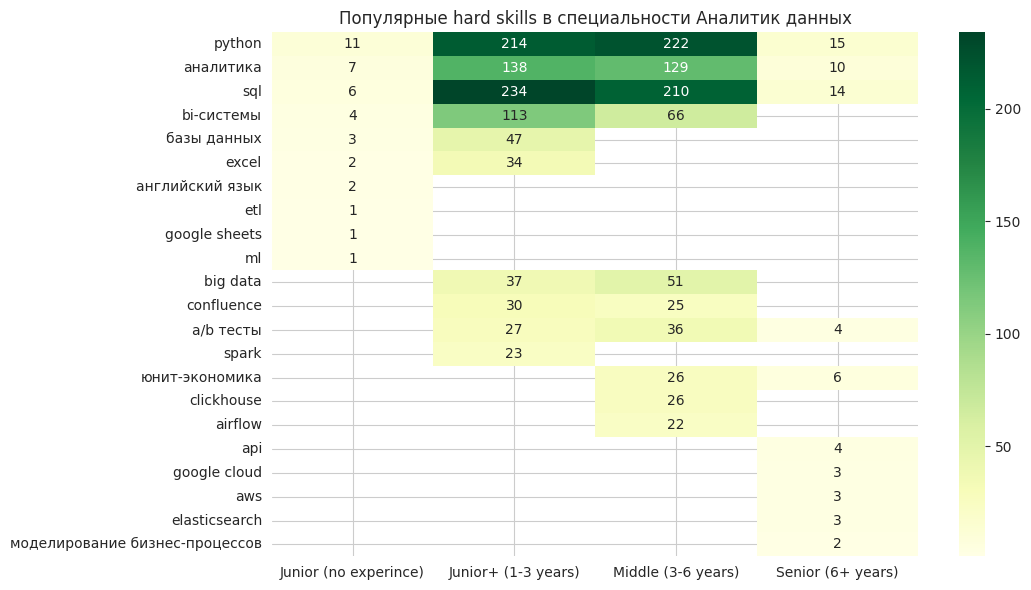

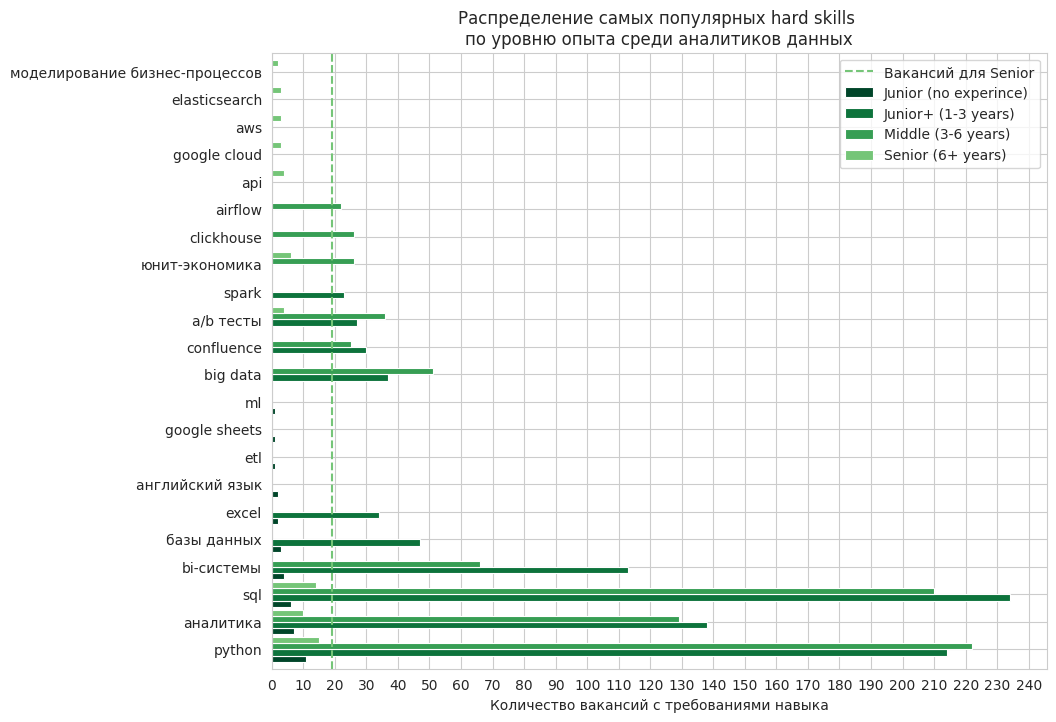

In [62]:
#применяем функцию generate_summary_table для аналитиков данных
summary_hard_da = generate_summary_table(df_skills, "Аналитик данных", "hard_skills", "hard skills", experience_levels)
#применяем функцию plot_summary_table для аналитиков данных
plot_summary_table(summary_hard_da, "hard skills", "Аналитиков данных", range(0, 250, 10), 19)

Важно помнить, что количество вакансий для аналитиков данных представлено небольшой выборкой, особенно для крайних уровней. Поэтому, делая предположения о том, каким должен быть идеальный кандидат на позицию Junior или Senior, мы будем максимально осторожны.

Кандидаты, претендующие на роль аналитика данных, обязательно должны обладать навыками работы с Python и SQL, а также умением проводить аналитические исследования в широком смысле этого термина. Это вполне логично для данной роли. Кроме того, среди важных навыков также следует выделить умение работы с инструментами визуализации данных.

Для уровня **Junior** наиболее критичными и предпочтительными являются упомянутые выше твёрдые навыки.

Для продвинутого уровня **Junior+** также ожидается владение следующими твёрдыми навыками:
- Работа с базами данных
- Знание математической статистики
- Опыт работы с Big Data
- Уверенное владение Excel
- Опыт использования Confluence
- Понимание A/B тестирования
Важно отметить, что для Junior+ чаще требуется владение навыком SQL, чем Python.

Для кандидатов на позицию **Middle** необходимы следующие твёрдые навыки:
- Продвинутое владение Python
- Уверенное владение SQL
- Знание основ аналитики
- Опыт работы с BI-системами
- Понимание Big Data
- Опыт A/B тестирования
- Навыки работы с Confluence
- Также плюсом будет владение Юнит-экономикой, ClickHouse и Apache Airflow.

Судя по имеющимся данным, идеальный **Senior** должен обладать следующими инструментами:
- Высокий уровень владения Python
- Продвинутое владение SQL
- Умение проводить Юнит-экономику
- Опыт работы с A/B тестированием
- Знание API

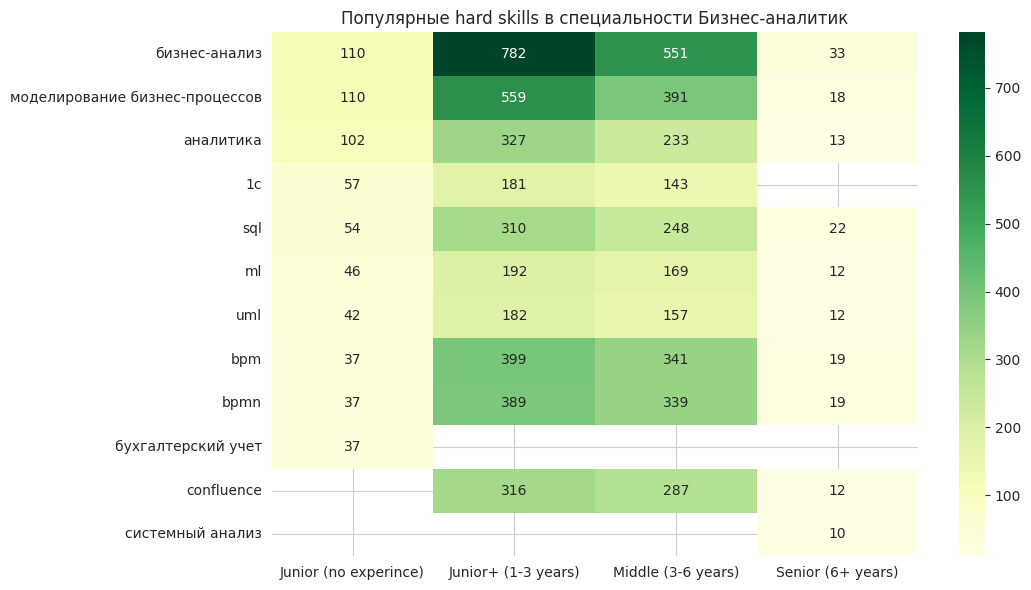

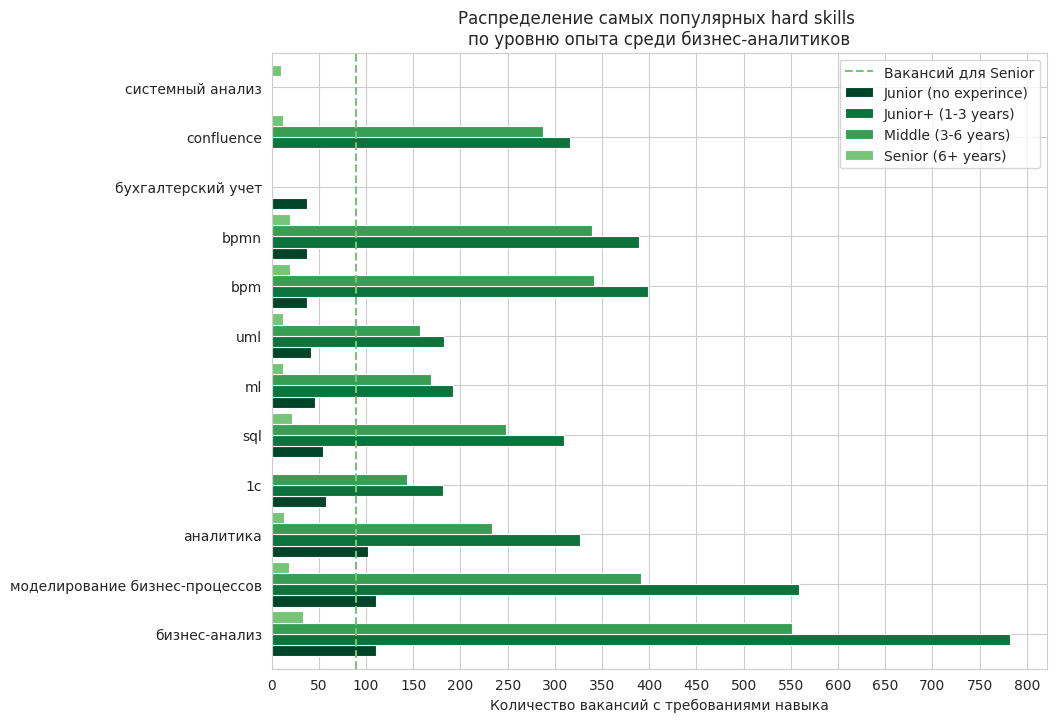

In [63]:
#применяем функцию generate_summary_table для бизнес-аналитиков
summary_hard_ba = generate_summary_table(df_skills, "Бизнес-аналитик", "hard_skills", "hard skills", experience_levels)
#применяем функцию plot_summary_table для бизнес-аналитиков
plot_summary_table(summary_hard_ba, "hard skills", "Бизнес-аналитиков", range(0, 850, 50), 89)

Вариантов вакансий на должность бизнес-аналитика гораздо больше, но среди них также выделяются позиции Junior и Senior, что объясняется меньшим количеством предложений. Если вакансии на позицию Junior можно сравнить с количеством предложений для аналитиков данных на позициях Junior+ и Middle, то выборка вакансий для Senior значительно уступает остальным грейдам. Это можно объяснить тем, что опытных специалистов пропорционально значительно меньше на рынке.

Несмотря на различия в опыте и уровне, ключевые навыки, необходимые для работы бизнес-аналитика, остаются по сути одинаковыми на протяжении всей карьеры:
- Моделирование бизнес-процессов
- Бизнес-анализ
- Аналитика.

Инструменты могут отличаться, но общий набор требуемых навыков остается почти неизменным.

Наиболее желанным стеком навыков для **Junior** являются:
- Знание 1С
- Основы SQL
- Знание основ машинного обучения (ML)
- Знание UML

На уровне **Junior+** и **Middle**, хотя соотношение может различаться, наиболее ценными являются:
- Знание BPM
- Знание BPMN
- Опыт работы с Confluence
- Уверенное владение SQL
- Знание основ машинного обучения (ML)

От идеального **Senior** ожидается владение следующими навыками:
- Уверенное владение SQL
- Знание BPMN
- Знание BPM
- Знание основ машинного обучения (ML)
- Знание UML
- Работа с Confluence

### Самые важные soft skils

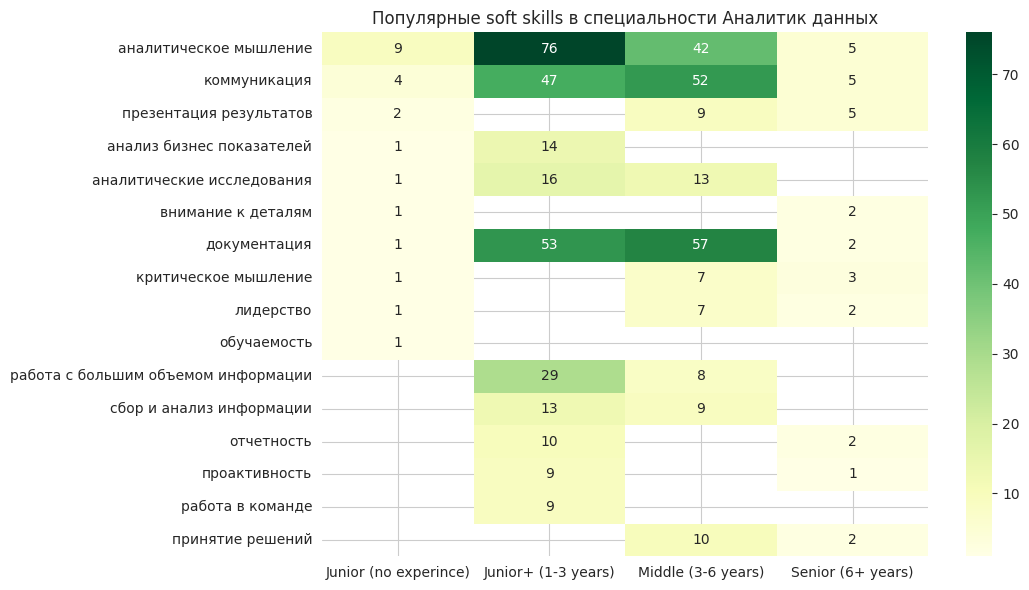

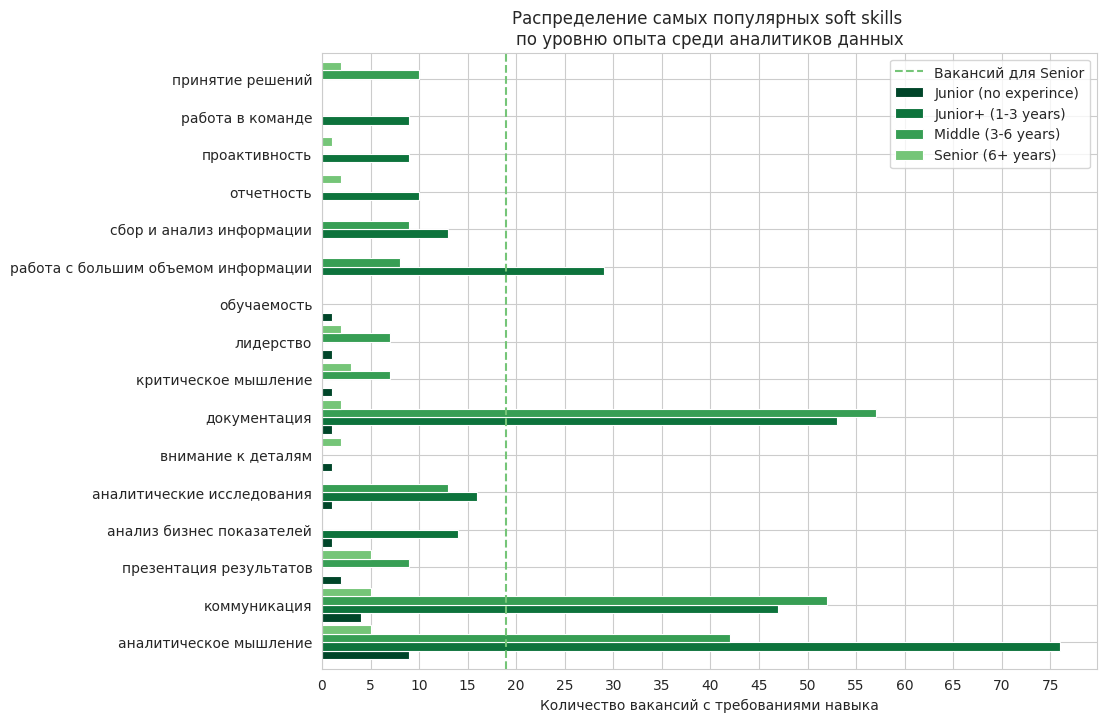

In [64]:
#применяем функцию generate_summary_table для аналитиков данных
summary_soft_da = generate_summary_table(df_skills, "Аналитик данных", "soft_skills", "soft skills", experience_levels)
#применяем функцию plot_summary_table для аналитиков данных
plot_summary_table(summary_soft_da, "soft skills", "Аналитиков данных", range(0, 80, 5),19)

В ходе анализа вакансий для аналитиков данных было выявлено, что независимо от уровня опыта, определенные навыки остаются важными и востребованными.

На уровне **Junior** основное внимание уделяется развитию аналитического мышления, коммуникационных навыков и умению представлять результаты анализа в понятной форме.

Для уровня **Junior+** и **Middle** помимо перечисленных выше навыков также требуется умение работать с большим объемом информации и вести документацию, что свидетельствует о необходимости более глубокого погружения в аналитический процесс.

Наиболее высокий уровень **Senior** требует от кандидатов не только тщательного анализа данных и качественной коммуникации, но и критического мышления, лидерских качеств, способности принимать важные решения, а также ориентации на детали и ведения документации.

Таким образом, навыки аналитического мышления, коммуникации и умения работы с данными являются фундаментальными на всех уровнях опыта в данной области.


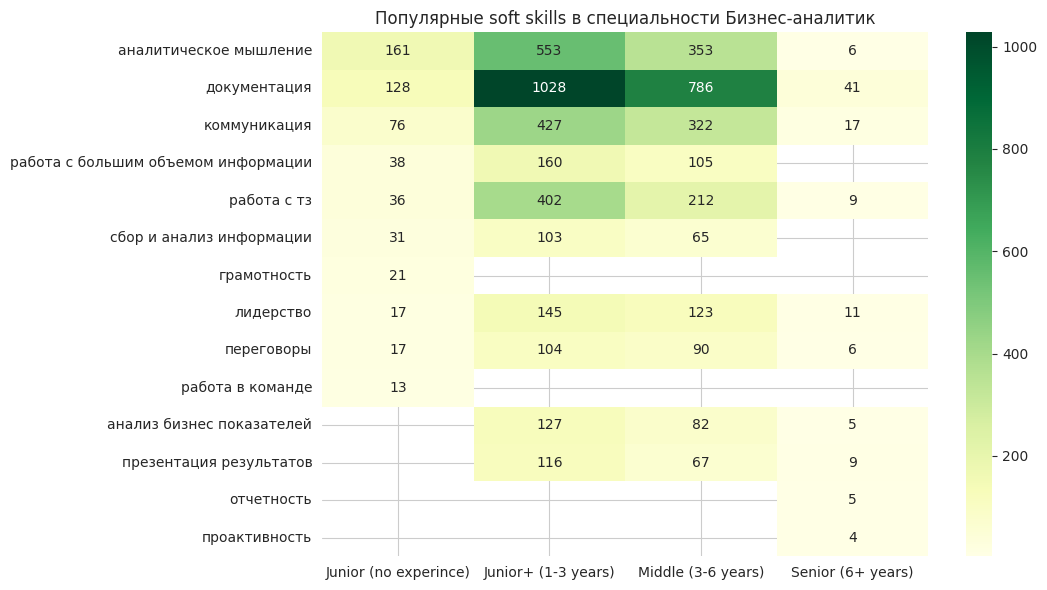

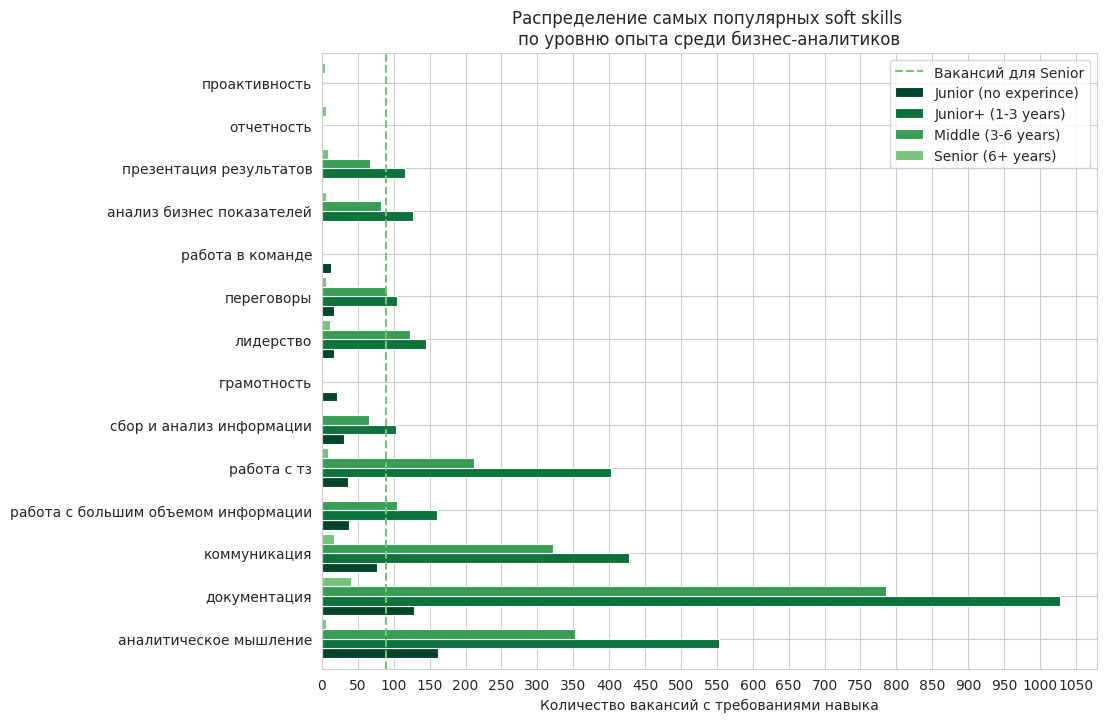

In [65]:
#применяем функцию generate_summary_table для бизнес-аналитиков
summary_soft_ba = generate_summary_table(df_skills, "Бизнес-аналитик", "soft_skills", "soft skills", experience_levels)
#применяем функцию plot_summary_table для бизнес-аналитиков
plot_summary_table(summary_soft_ba, "soft skills", "Бизнес-аналитиков", range(0, 1100, 50),89)

Проведенный анализ вакансий для бизнес-аналитиков демонстрирует, что на всех уровнях опыта существует определенный набор ключевых мягких навыков, необходимых для успешной работы в данной области.

На уровне **Junior** наибольшее внимание уделяется навыкам работы с документацией, коммуникации и способности эффективно обрабатывать большие объемы информации, что свидетельствует о важности внимательного и ответственного подхода к основным аспектам работы бизнес-аналитика.

Для уровня **Junior+** и **Middle** ключевыми soft skills являются умение вести документацию, качественная коммуникация, а также способность работать с техническим заданием и большим объемом информации. Отличительной чертой на этом уровне является также умение руководить, что подчеркивает важность лидерских качеств для достижения успеха в данной должности.

На позиции **Senior** наибольший упор делается на навыки работы с документацией, качественную коммуникацию и лидерство. Также важным является опыт презентации результатов анализа и способность принимать стратегические решения на основе полученных данных.

Таким образом, независимо от уровня опыта, успешный бизнес-аналитик должен обладать определенным набором мягких навыков, позволяющих ему эффективно выполнять поставленные задачи и достигать поставленных целей.


### Определение типичного места работы

#### Работодатели

In [66]:
#топ-10 для junior у аналитиков данных
employers_da_junior = (df.query('job == "Аналитик данных" and experience == "Junior (no experince)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_da_junior.index.names = ['Топ-10 работодателей'] #переименуем индексы
employers_da_junior.columns = ['Количество вакансий'] #переименуем столбец
#высчитаем долю от количества junior из таблицы выше
employers_da_junior['Доля по грейду'] = round((employers_da_junior['Количество вакансий'] / 25) * 100,1)
#выведем сводную таблицу
employers_da_junior

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
СБЕР,4,16.0
"РЕСО-Гарантия, САО",4,16.0
Компания CADesign,2,8.0
DNS Технологии,1,4.0
РЕТЕНТ,1,4.0
ННФормат,1,4.0
Марс,1,4.0
МТС,1,4.0
Литрес,1,4.0


Из полученной таблицы видно, что ТОП-10 работодателей для аналитиков данных на позицию Junior включают компании СБЕР, РЕСО-Гарантия и компанию CADesign. СБЕР и РЕСО-Гарантия предлагают по 4 вакансии, что составляет 16% от общего количества вакансий на данной позиции.

In [67]:
#топ-10 для junior у бизнес-аналитиков
employers_ba_junior = (df.query('job == "Бизнес-аналитик" and experience == "Junior (no experince)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_ba_junior.index.names = ['Топ-10 работодателей']
employers_ba_junior.columns = ['Количество вакансий']
employers_ba_junior['Доля по грейду'] = round((employers_ba_junior['Количество вакансий'] / 364) * 100,1)
employers_ba_junior

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
Aston,59,16.2
Апогей Крд,10,2.7
Апогей-ЕКБ,10,2.7
Changellenge,7,1.9
Компания Апогей (1С-франчайзи),7,1.9
"МАГНИТ, Розничная сеть",6,1.6
М.Видео-Эльдорадо,5,1.4
А энд М Электроинструменты,4,1.1
a1qa (ООО ITRANSITION),4,1.1


Из данной таблицы видно, что компании Aston, Апогей Крд, Апогей-ЕКБ и Changellenge являются наиболее привлекательными работодателями для бизнес-аналитиков на позиции Junior. Компания Aston лидирует с 59 вакансиями, что составляет 16,2% от общего количества вакансий среди работодателей.

In [68]:
#топ-10 для junior+ у аналитиков данных
employers_da_junior_pl = (df.query('job == "Аналитик данных" and experience == "Junior+ (1-3 years)"')
                            .pivot_table(index='employer', values='id', aggfunc='count')
                            .sort_values(by='id', ascending=False).head(10))

employers_da_junior_pl.index.names = ['Топ-10 работодателей']
employers_da_junior_pl.columns = ['Количество вакансий']
employers_da_junior_pl['Доля по грейду'] = round((employers_da_junior_pl['Количество вакансий'] / 387) * 100,1)
employers_da_junior_pl

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
СБЕР,65,16.8
МТС,25,6.5
WILDBERRIES,15,3.9
"МАГНИТ, Розничная сеть",10,2.6
PARI,7,1.8
РОСБАНК,7,1.8
билайн,5,1.3
Finstar Financial Group,5,1.3
ПСБ (ПАО «Промсвязьбанк»),4,1.0


Из таблицы видно, что среди работодателей больше всего открытых вакансий для аналитиков данных на позициях Junior+ в компаниях СБЕР, МТС, WILDBERRIES и МАГНИТ. Они предлагают в сумме четверть имеющихся вакансий. Лидером по количеству вакансий среди топовых работодателей является СБЕР, который предлагает 65 вакансий, что составляет 16,8% от общего числа.

In [69]:
#топ-10 для junior+ у бизнес-аналитиков
employers_ba_junior_pl = (df.query('job == "Бизнес-аналитик" and experience == "Junior+ (1-3 years)"')
                            .pivot_table(index='employer', values='id', aggfunc='count')
                            .sort_values(by='id', ascending=False).head(10))

employers_ba_junior_pl.index.names = ['Топ-10 работодателей']
employers_ba_junior_pl.columns = ['Количество вакансий']
employers_ba_junior_pl['Доля по грейду'] = round((employers_ba_junior_pl['Количество вакансий'] / 2122) * 100,1)
employers_ba_junior_pl

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
Банк ВТБ (ПАО),46,2.2
"МАГНИТ, Розничная сеть",37,1.7
СБЕР,36,1.7
Ozon,20,0.9
ПСБ (ПАО «Промсвязьбанк»),19,0.9
Комус,19,0.9
МТС,16,0.8
Delko,15,0.7
Правительство Москвы,15,0.7


 ТОП-10 работодателей для бизнес-аналитиков на позиции Junior+ включает в себя такие компании, как Банк ВТБ (ПАО), "Магнит", "Сбер" и Ozon. Лидером по количеству вакансий среди них является Банк ВТБ (ПАО) с 46 вакансиями, что составляет всего 2,2% от общего числа.

In [70]:
#топ-10 для middle у аналитиков данных
employers_da_middle = (df.query('job == "Аналитик данных" and experience == "Middle (3-6 years)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_da_middle.index.names = ['Топ-10 работодателей']
employers_da_middle.columns = ['Количество вакансий']
employers_da_middle['Доля по грейду'] = round((employers_da_middle['Количество вакансий'] / 355) * 100,1)
employers_da_middle

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
СБЕР,32,9.0
Playrix,21,5.9
WILDBERRIES,21,5.9
«UZUM TECHNOLOGIES».,10,2.8
USETECH,9,2.5
Maxim technology,8,2.3
Mayflower,7,2.0
КАЗАНЬЭКСПРЕСС,7,2.0
Fundraise Up,6,1.7


Из данной таблицы видно, что компании СБЕР, Playrix и WILDBERRIES занимают лидирующие позиции среди работодателей для аналитиков данных на позиции Middle. СБЕР предлагает 32 вакансии, что составляет 9% от общего числа.

In [71]:
#топ-10 для middle у бизнес-аналитиков
employers_ba_middle = (df.query('job == "Бизнес-аналитик" and experience == "Middle (3-6 years)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_ba_middle.index.names = ['Топ-10 работодателей']
employers_ba_middle.columns = ['Количество вакансий']
employers_ba_middle['Доля по грейду'] = round((employers_ba_middle['Количество вакансий'] / 1596) * 100,1)
employers_ba_middle

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
Банк ВТБ (ПАО),42,2.6
"Иннотех, Группа компаний",21,1.3
Тинькофф,20,1.3
"СИБУР, Группа компаний",19,1.2
СБЕР,18,1.1
Т1,18,1.1
Комус,17,1.1
Directum,16,1.0
Ozon,16,1.0


Из предоставленной таблицы можно увидеть, что ТОП-10 работодателей для бизнес-аналитиков на позиции Middle включает финансовые учреждения, такие как Банк ВТБ и Тинькофф, а также компании из других секторов, такие как Иннотех, Группа компаний и СИБУР, Группа компаний. Банк ВТБ лидирует с 42 вакансиями, что составляет 2,6% от общего числа. Это свидетельствует о высоком спросе на бизнес-аналитиков в различных отраслях экономики, включая банковскую и промышленную сферы.

In [72]:
#топ-10 для senior у аналитиков данных
employers_da_senior = (df.query('job == "Аналитик данных" and experience == "Senior (6+ years)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_da_senior.index.names = ['Топ-10 работодателей']
employers_da_senior.columns = ['Количество вакансий']
employers_da_senior['Доля по грейду'] = round((employers_da_senior['Количество вакансий'] / 19) * 100,1)
employers_da_senior

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
ТРТ,3,15.8
ANABAR,2,10.5
Wagner and Experts,2,10.5
Деловые Линии,2,10.5
Леруа Мерлен,2,10.5
Antal Talent,1,5.3
Connectivity Solutions (Коннективити Солюшнз),1,5.3
FuturHealth,1,5.3
SP,1,5.3


Из выведенной таблицы видно, что в ТОП-10 работодателей для аналитиков данных на позиции Senior входят компании из различных отраслей, включая торговые сети, транспортные и логистические компании, агентства недвижимости и консалтинговые агентства. Хотя количество вакансий не так велико, как для нижних уровней, мы можем выделить лидера по количеству предлагаемых вакансий: ТРТ с 3 вакансиями, что составляет 15,8% от общего числа.

In [73]:
#топ-10 для senior у бизнес-аналитиков
employers_ba_senior = (df.query('job == "Бизнес-аналитик" and experience == "Senior (6+ years)"')
                         .pivot_table(index='employer', values='id', aggfunc='count')
                         .sort_values(by='id', ascending=False).head(10))
employers_ba_senior.index.names = ['Топ-10 работодателей']
employers_ba_senior.columns = ['Количество вакансий']
employers_ba_senior['Доля по грейду'] = round((employers_ba_senior['Количество вакансий'] / 89) * 100,1)
employers_ba_senior

,Количество вакансий,Доля по грейду
Топ-10 работодателей,,
Playrix,6,6.7
1-й Советник,3,3.4
CUSTIS,3,3.4
Ультиматек,3,3.4
Т1,3,3.4
"Оптиком, компания",3,3.4
1221Системс,3,3.4
Ultima BusinessWare,2,2.2
ФК Гранд Капитал,2,2.2


Из данной таблицы видно, что компания Playrix занимает лидирующую позицию по количеству вакансий Senior бизнес-аналитиков, предлагая 6 позиций, что составляет 6,7% от общего числа вакансий. Это указывает на высокий спрос на опытных специалистов в данной области. Помимо Playrix, другие компании, такие как 1-й Советник, CUSTIS, Ультиматек, Т1 и Оптиком, также предлагают большое количество вакансий для Senior бизнес-аналитиков. Это свидетельствует о востребованности опытных специалистов в данной области на рынке труда и о наличии разнообразных возможностей для их карьерного роста.


---


Анализ уже изученных таблиц показывает, что бизнес-аналитиков ищет очень большое количество компаний, от самых начинающих до опытных и ценных специалистов уровня Senior. В расматриваемый период это направление является более востребованным.

#### Зарплата

Принцип расчета распределения количества предложений по грейдам, в зависимости от зарплаты, занятости и графика работы, одинаков. Создадим функцию, которая поможет нам визуализировать эти распределения.

In [74]:
#функция для создания сдвоенных столбчатых графиков
def plot_summary_distribution(summary_table1, summary_table2, title1, title2, xlabel, rotation):
    #задаем размер
    plt.figure(figsize=(16, 5))
    #строим первую сгруппированную столбчатую гистограмму
    ax1 = plt.subplot(1, 2, 1)
    summary_table1.plot(kind='bar', stacked=False, linewidth=0.8, width=0.9, ax=ax1)
    ax1.set_ylabel('Количество вакансий')
    ax1.set_xlabel(xlabel)
    ax1.set_title(title1)
    ax1.legend(title='Уровень опыта')
    plt.xticks(rotation=rotation)
    #строим вторую сгруппированную столбчатую гистограмму
    ax2 = plt.subplot(1, 2, 2)
    summary_table2.plot(kind='bar', stacked=False, linewidth=0.8, width=0.9, ax=ax2)
    ax2.set_ylabel('Количество вакансий')
    ax2.set_xlabel(xlabel)
    ax2.set_title(title2)
    ax2.legend(title='Уровень опыта')
    plt.xticks(rotation=rotation)
    #показываем оба графика на одной горизонтальной линии
    plt.tight_layout()
    plt.show()

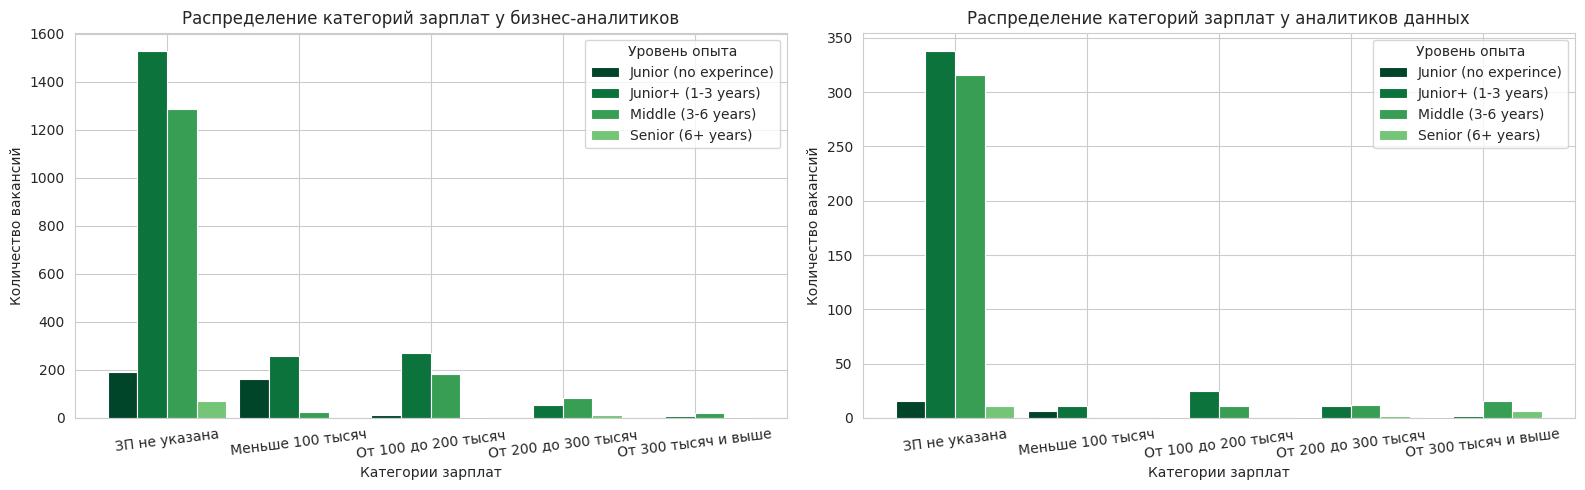

Сводная таблица по бизнес-аналитикам


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
salary_bin,,,,
ЗП не указана,191.0,1529.0,1285.0,71.0
Меньше 100 тысяч,160.0,259.0,26.0,NaN
От 100 до 200 тысяч,13.0,272.0,182.0,4.0
От 200 до 300 тысяч,NaN,55.0,82.0,10.0
От 300 тысяч и выше,NaN,7.0,21.0,4.0


____________________________________________________________________________________________________
Сводная таблица по аналитикам данных


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
salary_bin,,,,
ЗП не указана,16.0,338.0,316.0,11.0
Меньше 100 тысяч,6.0,11.0,NaN,NaN
От 100 до 200 тысяч,1.0,25.0,11.0,NaN
От 200 до 300 тысяч,1.0,11.0,12.0,2.0
От 300 тысяч и выше,1.0,2.0,16.0,6.0


In [75]:
#сводная таблица по бизнес-аналитикам с распределением зарплат
salary_ba = (df.query('job == "Бизнес-аналитик"')
               .pivot_table(index='salary_bin', columns='experience', values='id', aggfunc='count'))
#сводная таблица по аналитикам данных с распределением зарплат
salary_da = (df.query('job == "Аналитик данных"')
               .pivot_table(index='salary_bin', columns='experience', values='id', aggfunc='count'))
#применяем функцию plot_summary_distribution
plot_summary_distribution(salary_ba, salary_da,
                          'Распределение категорий зарплат у бизнес-аналитиков',
                          'Распределение категорий зарплат у аналитиков данных',
                          'Категории зарплат', 7)
print('Сводная таблица по бизнес-аналитикам')
display(salary_ba)
print('__'* 50)
print('Сводная таблица по аналитикам данных')
salary_da

Из распределения количества вакансий по категориям заработной платы для аналитиков данных и бизнес-аналитиков следует, что большинство работодателей при публикации вакансий не указывают размер заработной платы. Это означает, что информация о зарплате может быть предоставлена на этапе собеседования или в индивидуальном порядке.

**Бизнес-аналитики:**

- Наиболее часто встречающийся диапазон заработной платы для Junior и Junior+ бизнес-аналитиков — «Меньше 100 тысяч», что говорит о том, что начальные уровни оплаты труда в данной области обычно невысокие.
- С увеличением опыта уровень заработной платы также увеличивается. Для Middle и Senior бизнес-аналитиков более распространены диапазоны «От 100 до 200 тысяч» и «От 200 до 300 тысяч и выше».

**Аналитики данных:**

- Значительно меньше вакансий с указанием заработной платы в сравнении с бизнес-аналитиками.
- Для Junior и Junior+ аналитиков данных также наиболее распространен диапазон «Меньше 100 тысяч», что указывает на низкий начальный уровень заработной платы в этой области.
- Уровень заработной платы для Middle и Senior аналитиков данных в основном находится в диапазоне «От 200 до 300 тысяч и выше», что свидетельствует о том, что с ростом опыта и уровня ответственности увеличивается и заработная плата.

#### Тип занятости

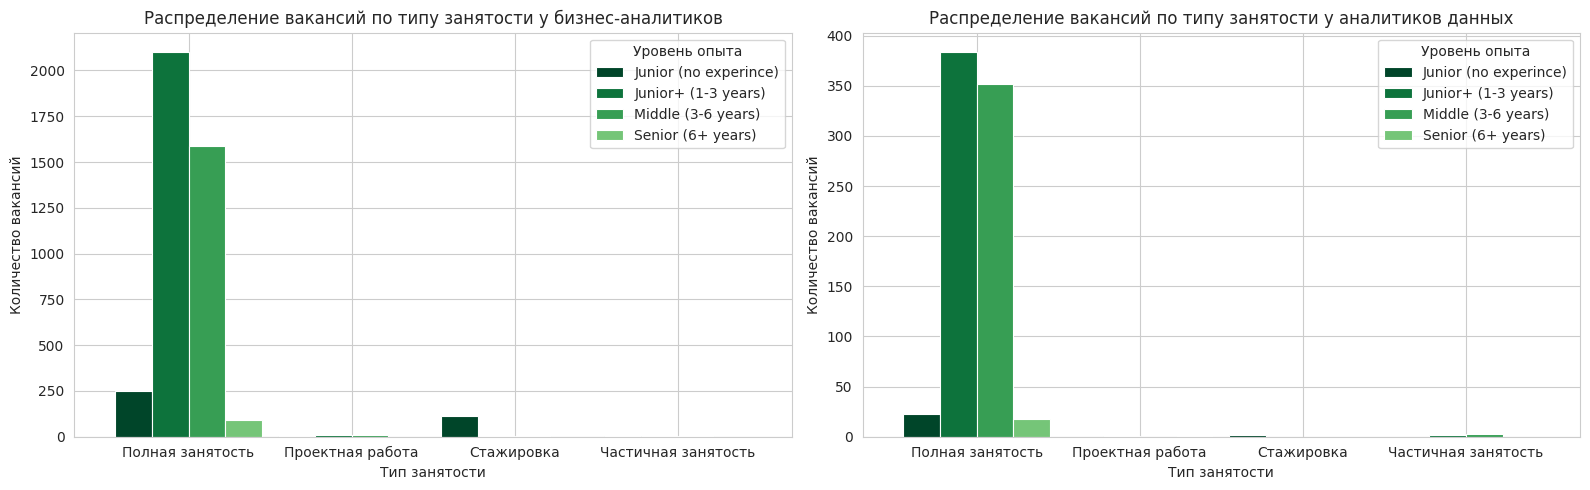

Сводная таблица по бизнес-аналитикам


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
employment,,,,
Полная занятость,248.0,2102.0,1585.0,89.0
Проектная работа,2.0,9.0,8.0,NaN
Стажировка,113.0,6.0,1.0,NaN
Частичная занятость,1.0,5.0,2.0,NaN


____________________________________________________________________________________________________
Сводная таблица по аналитикам данных


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
employment,,,,
Полная занятость,23.0,384.0,352.0,18.0
Проектная работа,NaN,1.0,NaN,1.0
Стажировка,2.0,NaN,NaN,NaN
Частичная занятость,NaN,2.0,3.0,NaN


In [76]:
#сводная таблица по бизнес-аналитикам с распределением по типу занятости
employment_ba = (df.query('job == "Бизнес-аналитик"')
                   .pivot_table(index='employment', columns='experience', values='id', aggfunc='count'))
#сводная таблица по аналитикам данных с распределением по типу занятости
employment_da = (df.query('job == "Аналитик данных"')
                   .pivot_table(index='employment', columns='experience', values='id', aggfunc='count'))
#применяем функцию plot_summary_distribution
plot_summary_distribution(employment_ba, employment_da,
                          'Распределение вакансий по типу занятости у бизнес-аналитиков',
                          'Распределение вакансий по типу занятости у аналитиков данных',
                          'Тип занятости', 0)
print('Сводная таблица по бизнес-аналитикам')
display(employment_ba)
print('__'* 50)
print('Сводная таблица по аналитикам данных')
employment_da

Из анализа графиков распределения вакансий по типу занятости среди бизнес-аналитиков и аналитиков данных можно сделать следующие выводы:

**Бизнес-аналитики:**

- Большинство бизнес-аналитиков работают на полную занятость. Это особенно заметно среди Junior+ и Middle уровней, где количество вакансий на полную занятость значительно превышает другие виды занятости.
- Проектная работа и стажировки встречаются в гораздо меньшем количестве, что свидетельствует о том, что они менее распространены в данной области.

**Аналитики данных:**

- Вакансии для аналитиков данных, как правило, предполагают полную занятость. Наибольшее количество вакансий на полную занятость наблюдается для специалистов Junior+ и Middle.
- Проектная работа встречается редко, а стажировки еще реже. Возможно, это связано с тем, что данная область требует определенного уровня навыков и опыта для эффективного участия в проектах.


#### График работы

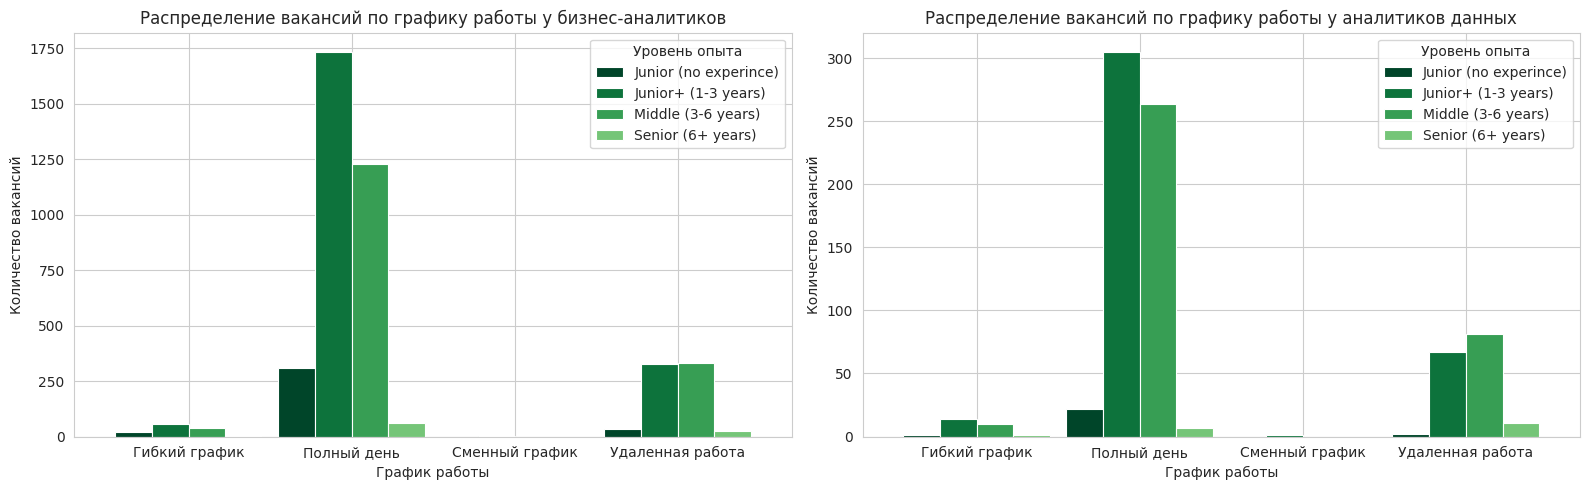

Сводная таблица по бизнес-аналитикам


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
schedule,,,,
Гибкий график,19.0,55.0,39.0,2.0
Полный день,311.0,1735.0,1227.0,62.0
Сменный график,NaN,4.0,NaN,NaN
Удаленная работа,34.0,328.0,330.0,25.0


____________________________________________________________________________________________________
Сводная таблица по аналитикам данных


experience,Junior (no experince),Junior+ (1-3 years),Middle (3-6 years),Senior (6+ years)
schedule,,,,
Гибкий график,1.0,14.0,10.0,1.0
Полный день,22.0,305.0,264.0,7.0
Сменный график,NaN,1.0,NaN,NaN
Удаленная работа,2.0,67.0,81.0,11.0


In [77]:
#сводная таблица по бизнес-аналитикам с распределением по графику работы
schedule_ba = (df.query('job == "Бизнес-аналитик"')
                 .pivot_table(index='schedule', columns='experience', values='id', aggfunc='count'))
#сводная таблица по аналитикам данных с распределением по графику работы
schedule_da = (df.query('job == "Аналитик данных"')
                 .pivot_table(index='schedule', columns='experience', values='id', aggfunc='count'))
#применяем функцию plot_summary_distribution
plot_summary_distribution(schedule_ba, schedule_da,
                          'Распределение вакансий по графику работы у бизнес-аналитиков',
                          'Распределение вакансий по графику работы у аналитиков данных',
                          'График работы', 0)
print('Сводная таблица по бизнес-аналитикам')
display(schedule_ba)
print('__'* 50)
print('Сводная таблица по аналитикам данных')
schedule_da

Согласно данным о распределении количества вакансий бизнес-аналитиков и аналитиков данных в зависимости от графика работы, мы можем сделать следующие выводы.

**Бизнес-аналитики:**

- Большинство бизнес-аналитиков работают полный рабочий день. Это характерно для всех уровней опыта, но особенно заметно для вакансий  Junior+ и Middle.
- Удаленная работа также является распространенной среди бизнес-аналитиков, особенно для Junior+ и Middle уровней.
- Гибкий график встречается реже, преимущественно для Junior и Junior+ уровней, но не является основным вариантом графика работы.


**Аналитики данных:**

- Как и бизнес-аналитики, большинство аналитиков данных также работают полный рабочий день, особенно на Junior+ и Middle уровнях.
- Удаленная работа также популярна среди аналитиков данных на всех уровнях опыта, хотя и менее распространена, чем среди бизнес-аналитиков.
- Гибкий график используется в меньшей степени, особенно для Junior и Senior уровней, но может быть предпочтителен для Junior+ и Middle.

Стоит обратить внимание, что выводы могут быть не совсем точными из-за недостаточного количества данных.

### Расчет помесячной динамики количества вакансий

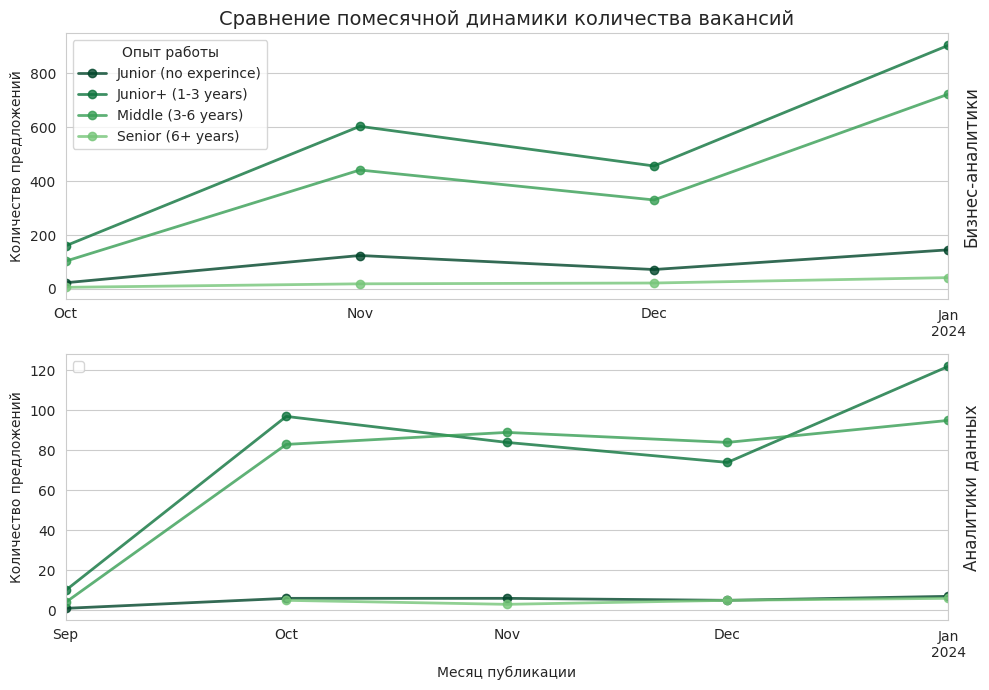

job              Аналитик данных                                         \
experience Junior (no experince) Junior+ (1-3 years) Middle (3-6 years)   
month                                                                     
2023-09                      1.0                10.0                4.0   
2023-10                      6.0                97.0               83.0   
2023-11                      6.0                84.0               89.0   
2023-12                      5.0                74.0               84.0   
2024-01                      7.0               122.0               95.0   

job                                Бизнес-аналитик                      \
experience Senior (6+ years) Junior (no experince) Junior+ (1-3 years)   
month                                                                    
2023-09                  NaN                   NaN                 NaN   
2023-10                  5.0                  23.0               160.0   
2023-11                  3.0                 124.0               603.0   
2023-12                  5.0                  72.0               456.0   
2024-01                  6.0                 145.0               903.0   

job                                              
experience Middle (3-6 years) Senior (6+ years)  
month                                            
2023-09                   NaN               NaN  
2023-10                 103.0               6.0  
2023-11                 441.0              19.0  
2023-12                 330.0              22.0  
2024-01                 722.0              42.0

In [78]:
#задаём размеры графика
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 7))
#график помесячной динамики количества вакансий для бизнес-аналитика
(df.query('job == "Бизнес-аналитик"')
 .pivot_table(index='month', columns='experience', values='id', aggfunc='count')
 .plot(style='-o', grid=True, ax=axes[0], linewidth=2, alpha=0.8))
axes[0].set_xlabel('')
axes[0].set_ylabel('Количество предложений', fontsize=10)
axes[0].set_title('Сравнение помесячной динамики количества вакансий', fontsize=14)
axes[0].legend(fontsize=10, title='Опыт работы')
axes[0].annotate('Бизнес-аналитики',
                 xy=(1, 0.5), xycoords='axes fraction',
                 xytext=(10, 0), textcoords='offset points',
                 ha='left', va='center', rotation=90, fontsize=12)
#график помесячной динамики количества вакансий для аналитика данных
(df.query('job == "Аналитик данных"')
 .pivot_table(index='month', columns='experience', values='id', aggfunc='count')
 .plot(style='-o', grid=True, ax=axes[1], linewidth=2, alpha=0.8))
axes[1].legend([])
axes[1].set_xlabel('Месяц публикации', fontsize=10)
axes[1].set_ylabel('Количество предложений', fontsize=10)
axes[1].annotate('Аналитики данных',xy=(1, 0.5),xycoords='axes fraction',xytext=(10, 0),
                 textcoords='offset points',ha='left',va='center',rotation=90, fontsize=12)
#отображаем графики
plt.tight_layout()
plt.show()

df.pivot_table(index='month', columns=['job','experience'], values='id', aggfunc='count')

Исходя из информации о количестве вакансий для аналитиков данных и бизнес-аналитиков на hh.ru за период с конца сентября 2023 года по конец января 2024 года, можно сделать следующие выводы о помесячной динамике этого показателя:

**Аналитики данных:**
- В сентябре было немного вакансий, связанных с предложениями для аналитиков данных. Поэтому можно пренебречь этим месяцем.
- Количество вакансий существенно колеблется от месяца к месяцу, но в целом наблюдается тенденция к росту. Наибольший прирост наблюдается с октября по ноябрь, а затем рост остается умеренным.
- Наблюдается устойчивый рост вакансий на всех уровнях опыта, особенно для Junior+ и Middle.

**Бизнес-аналитики:**

- Как и для аналитиков данных, количество вакансий для бизнес-аналитиков также со временем увеличивается. Однако, в отличие от аналитиков данных, количество вакансий для бизнес-аналитиков имеет более сильные колебания.
- В ноябре 2023 года и январе 2024 года мы наблюдаем значительный рост вакансий для уровней Junior+ и Middle. В то же время, количество вакансий для уровня Senior остается относительно стабильным, с небольшим увеличением в ноябре 2023 года и январе 2024 года.

Общий тренд указывает на увеличение спроса на аналитиков данных и бизнес-аналитиков на рынке труда, особенно среди кандидатов с опытом работы от 1 года до 6 лет.


## **Выводы и рекомендации**

### Аналитик данных

Исходя из изученных данных, кандидаты, стремящиеся к роли аналитика данных, могут столкнуться с определенными ожиданиями и требованиями, которые могут различаться в зависимости от уровня опыта.

**Junior:**

- Кандидатам на позицию Junior необходимо иметь уверенные навыки работы с Python, SQL и инструментами визуализации данных.
- На этом уровне основное внимание уделяется развитию аналитического мышления, коммуникационных навыков и умению представлять результаты анализа в понятной форме.
- Рекомендуется активно развивать эти навыки и рассмотреть возможности работы в компаниях, таких как СБЕР, РЕСО-Гарантия и CADesign, которые предлагают много вакансий на этом уровне.
- Наиболее вероятный начальный уровень заработной платы составляет менее 100 тысяч рублей.
- Стоит рассчитывать на полную занятость, удаленная работа может быть доступна в редких предложениях.

**Junior+:**

- Для Junior+ кроме базовых навыков Python и SQL, требуется также опыт работы с базами данных, знание математической статистики, опыт работы с Big Data, Excel, Confluence и понимание A/B тестирования.
- Помимо технических навыков, необходимо развивать умение работать с большим объемом информации и вести документацию.
- Рекомендуется обратить внимание на вакансии в компаниях, таких как СБЕР, МТС, WILDBERRIES и МАГНИТ, которые предлагают много вакансий для Junior+ аналитиков данных.
- Можно ожидать уровень заработной платы от 100 до 200 тысяч.
- Предполагается полная занятость, но также возможна удаленная работа.

**Middle:**

- Для Middle аналитиков данных необходимо продвинутое владение Python и SQL, опыт работы с BI-системами, понимание Big Data, опыт A/B тестирования и навыки работы с Confluence. Дополнительным преимуществом будет владение Юнит-экономикой, ClickHouse и Apache Airflow.
- Идеальный кандидат стремится развивать лидерские качества и способность принимать важные решения.
- Рекомендуется рассмотреть возможности работы в компаниях, таких как СБЕР, Playrix и WILDBERRIES.
- Ожидать стоит уровень заработной платы от 200 тысяч рублей и выше.
- Работа предлагается на полную занятость, возможна удаленная работа и гибкий график.

**Senior:**

- Для этого уровня требуется высокий уровень владения Python и SQL, умение проводить Юнит-экономику и опыт работы с A/B тестированием, а также знание API.
- На уровне Senior основное внимание уделяется развитию навыков критического мышления, лидерства и способности принимать важные решения на основе анализа данных.
- Поиск вакансий можно вести в различных отраслях, включая торговые сети, транспортные и логистические компании, агентства недвижимости и консалтинговые агентства, такие как ТРТ.
- На этом уровне опыта можно ожидать заработную плату от 200 тысяч и выше.
- Предполагается полная занятость, в редких случаях возможна удаленная работа и гибкий график.

### Бизнес-аналитик

Подготовка к карьере бизнес-аналитика требует освоения специфических навыков на каждом уровне опыта.

**Junior:**
- При отборе кандидатов основное внимание уделяется знаниям 1С, основам SQL, машинного обучения и UML.
- Важно иметь навыки работы с документацией, коммуникации и умение эффективно обрабатывать большие объемы информации.
- Кандидаты могут рассмотреть вакансии в компаниях Aston, Апогей Крд, Апогей-ЕКБ и Changellenge.
- Ожидаемый начальный уровень заработной платы меньше 100 тысяч рублей.
- Как правило, предполагается полная занятость, возможна удаленная работа.

**Junior+:**
- Важно обладать знаниями в области BPM и BPMN, иметь опыт работы с Confluence, уверенно владеть SQL и понимать машинное обучение.
- Коммуникативные навыки, способность вести документацию и работать с техзаданиями становятся все более важными.
- Рекомендуется рассмотреть возможности трудоустройства в таких компаниях, как Банк ВТБ (ПАО), МАГНИТ, СБЕР и Ozon.
- Уровень заработной платы ожидается ниже 100 тысяч рублей.
- Предполагается полная занятость, возможна удаленная работа.

**Middle:**
- Для Middle важными навыками являются умение работать с BPM и BPMN, опыт использования Confluence, уверенное владение SQL и основами машинного обучения.
- На этом уровне также важно умение руководить, вести документацию и качественно коммуницировать, а также способность работать с техническим заданием.
- Рекомендуется рассмотреть возможности в таких компаниях, как Банк ВТБ, Тинькофф, Иннотех, Группа компаний, СИБУР.
- Уровень заработной платы ожидается от 100 тысяч рублей и выше.
- Предполагается полная занятость, удаленная работа возможна, но реже, чем на более низких уровнях.

**Senior:**

Чтобы получить эту должность, нужно обладать следующими навыками:

- Глубокие знания SQL и BPM, BPMN, а также основ машинного обучения. Владение UML и опыт работы с Confluence.
- Кроме того, от кандидата ожидаются лидерские качества, способность к качественной коммуникации, умение принимать стратегические решения и навыки презентации результатов анализа.
- Рекомендуется рассмотреть возможности трудоустройства в таких компаниях, как Playrix, 1-й Советник, CUSTIS, Ультиматек, Т1 и Оптиком.
- Ожидаемый уровень заработной платы от 200 тысяч рублей и выше.
- Предполагается полная занятость, удаленная работа и гибкий график встречаются редко.

Эти рекомендации помогут определить наиболее подходящие возможности для развития карьеры в соответствии с текущим уровнем опыта и навыков.

## **Презентация**

Ссылка на презентацию в [Tableau Public](https://public.tableau.com/app/profile/helen.rusetska/viz/-_17092487211510/presentation)

На дашбордах нет выводов, но инфографика максимально наглядна.